In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import Pipeline

#from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

In [ ]:
orig_url = "https://drive.google.com/file/d/1z1R5Q1Ej65pURJYUHKmCs1C1cV5S28a9/view?usp=sharing"
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df_raw = pd.read_csv(dwn_url)
df = df_raw.copy()

In [ ]:
# column_to_drop = ["customer_id"]
# df = df.drop(columns=column_to_drop)  # Use drop with columns argument

# NA Management
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
df[['min_payments', 'credit_limit']] = knn_imputer.fit_transform(df[['min_payments', 'credit_limit']])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       8500 non-null   object 
 1   balance_account                   8500 non-null   float64
 2   purchases_amount                  8500 non-null   float64
 3   paid_advance                      8500 non-null   float64
 4   full_purchases                    8500 non-null   float64
 5   balance_frequency_update          8500 non-null   float64
 6   installments                      8500 non-null   float64
 7   purchases_frequency               8500 non-null   float64
 8   full_purchases_frequency          8500 non-null   float64
 9   purchases_installments_frequency  8500 non-null   float64
 10  cash_advance_frequency            8500 non-null   float64
 11  nr_cash_advances                  8500 non-null   int64  
 12  nr_pur

In [ ]:
df.head()

customer_id  balance_account  purchases_amount  paid_advance  \
0  tGEg8fT2eCgVxdwS         9.298409            107.60      0.000000   
1  stEDu20sSKOXomjg        52.666422            150.30      0.000000   
2  CEB2blrN3b88GsRe      1360.795674              0.00    462.861443   
3  0N0eBl8ySaZThxKE      2021.641161            363.18      0.000000   
4  6NLauoHUwtwOv4Wy        22.322374             95.00   1162.045833   

   full_purchases  balance_frequency_update  installments  \
0            0.00                  0.909091         107.6   
1            0.00                  1.000000         150.3   
2            0.00                  1.000000           0.0   
3          363.18                  1.000000           0.0   
4           95.00                  0.363636           0.0   

   purchases_frequency  full_purchases_frequency  \
0             0.909091                  0.000000   
1             1.000000                  0.000000   
2             0.000000                  0.000000   
3             1.000000                  1.000000   
4             0.083333                  0.083333   

   purchases_installments_frequency  cash_advance_frequency  nr_cash_advances  \
0                          0.818182                0.000000                 0   
1                          0.833333                0.000000                 0   
2                          0.000000                0.272727                 6   
3                          0.000000                0.000000                 0   
4                          0.000000                0.166667                 3   

   nr_purchases  credit_limit  fixed_rate_period     payments  min_payments  \
0            10        1000.0                 11    89.868853     89.711672   
1             6        1000.0                  6    54.722514     82.955180   
2             0        1500.0                 11   303.031979    443.781316   
3            13        2000.0                 12   704.240770    795.859808   
4             1        2500.0                 12  4094.261427     40.142262   

   full_payment_prc  
0          0.428571  
1          0.000000  
2          0.000000  
3          0.000000  
4          0.000000

In [ ]:
# Calculate derived features
df['Avg_Purchase_Amount'] = df['purchases_amount'] / df['nr_purchases']
df['Cash_Advance_Ratio'] = df['nr_cash_advances'] / df['cash_advance_frequency']
df['Purchase_to_Balance_Ratio'] = df['purchases_amount'] / df['balance_account']

# Handle potential infinity or NaN values resulting from division by zero
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)
df.head()


customer_id  balance_account  purchases_amount  paid_advance  \
0  tGEg8fT2eCgVxdwS         9.298409            107.60      0.000000   
1  stEDu20sSKOXomjg        52.666422            150.30      0.000000   
2  CEB2blrN3b88GsRe      1360.795674              0.00    462.861443   
3  0N0eBl8ySaZThxKE      2021.641161            363.18      0.000000   
4  6NLauoHUwtwOv4Wy        22.322374             95.00   1162.045833   

   full_purchases  balance_frequency_update  installments  \
0            0.00                  0.909091         107.6   
1            0.00                  1.000000         150.3   
2            0.00                  1.000000           0.0   
3          363.18                  1.000000           0.0   
4           95.00                  0.363636           0.0   

   purchases_frequency  full_purchases_frequency  \
0             0.909091                  0.000000   
1             1.000000                  0.000000   
2             0.000000                  0.000000   
3             1.000000                  1.000000   
4             0.083333                  0.083333   

   purchases_installments_frequency  ...  nr_cash_advances  nr_purchases  \
0                          0.818182  ...                 0            10   
1                          0.833333  ...                 0             6   
2                          0.000000  ...                 6             0   
3                          0.000000  ...                 0            13   
4                          0.000000  ...                 3             1   

   credit_limit  fixed_rate_period     payments  min_payments  \
0        1000.0                 11    89.868853     89.711672   
1        1000.0                  6    54.722514     82.955180   
2        1500.0                 11   303.031979    443.781316   
3        2000.0                 12   704.240770    795.859808   
4        2500.0                 12  4094.261427     40.142262   

   full_payment_prc  Avg_Purchase_Amount  Cash_Advance_Ratio  \
0          0.428571            10.760000            0.000000   
1          0.000000            25.050000            0.000000   
2          0.000000             0.000000           22.000022   
3          0.000000            27.936923            0.000000   
4          0.000000            95.000000           17.999964   

   Purchase_to_Balance_Ratio  
0                  11.571872  
1                   2.853811  
2                   0.000000  
3                   0.179646  
4                   4.255820  

[5 rows x 21 columns]

In [ ]:
#to_drop = ["customer_id",'full_purchases', "cash_advance_frequency", "purchases_installments_frequency",'purchases_amount','nr_purchases','nr_cash_advances','cash_advance_frequency','purchases_amount','balance_account']
#df_train = df.drop(columns=to_drop)

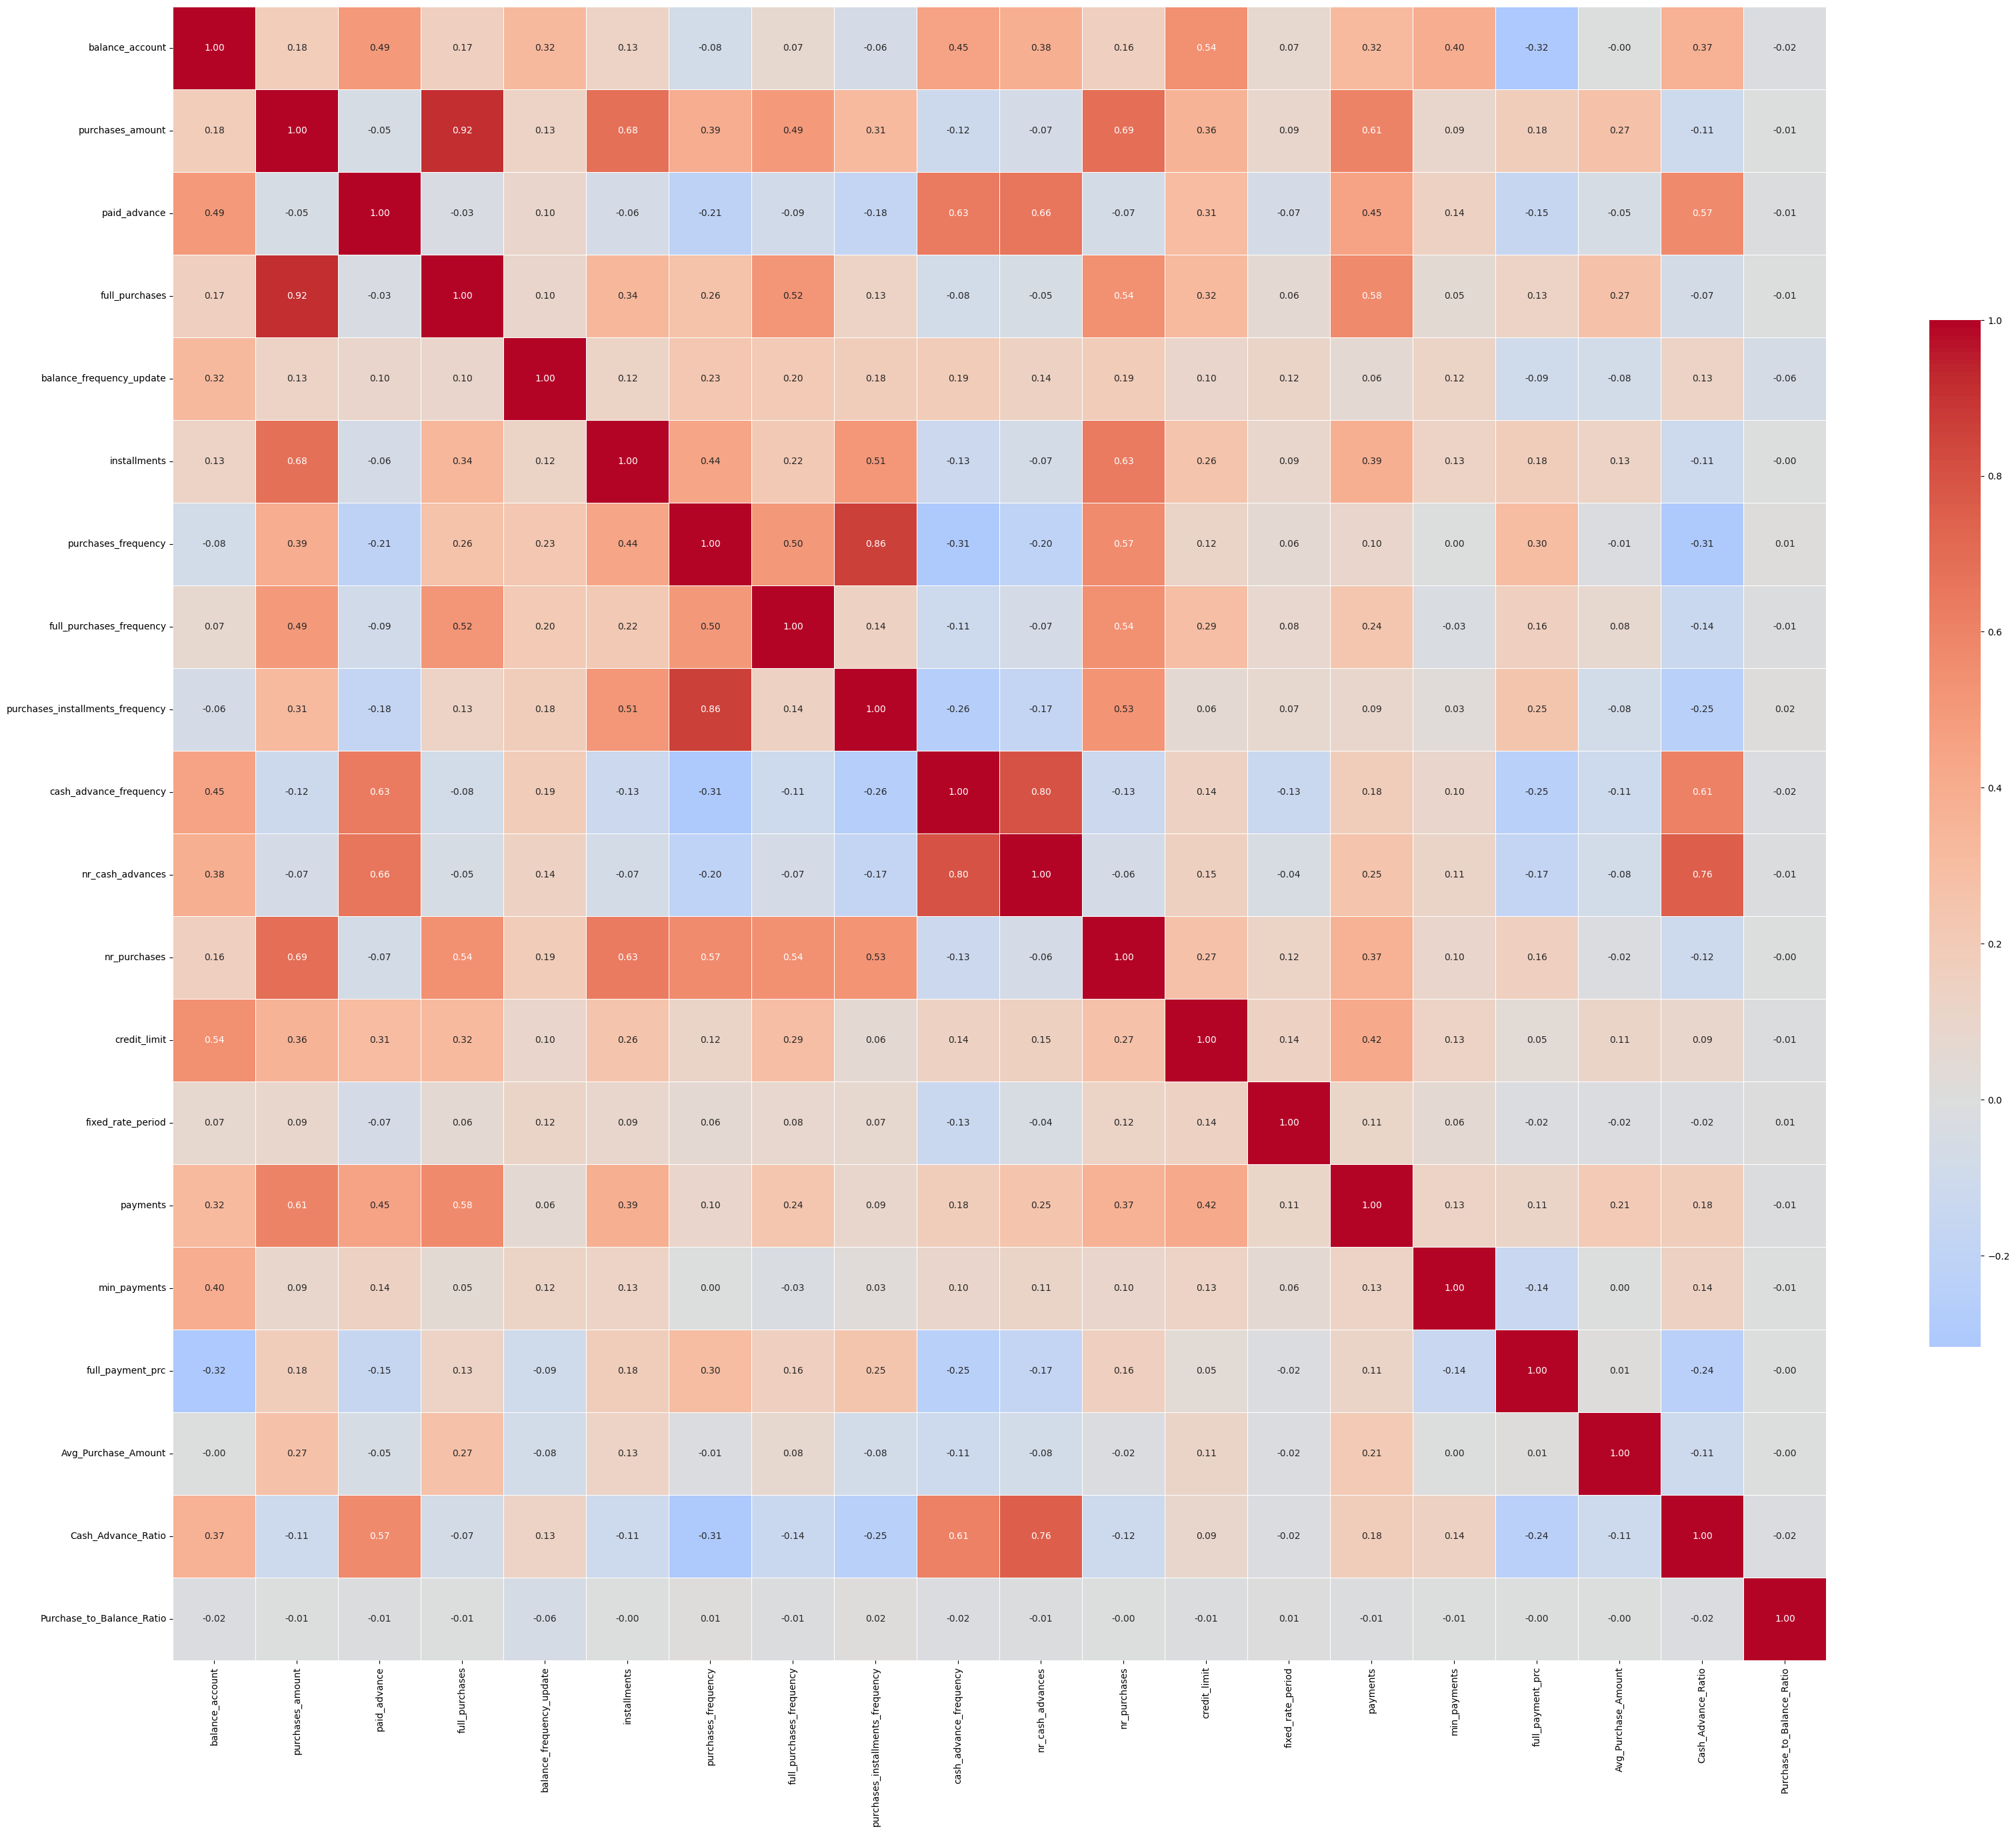

In [ ]:
# We are going to drop any features that have a correlation score higher than 0.80
# To drop: ['full_purchases', 'purchases_installments_frequency']
x=df.drop(columns=["customer_id"])
corr_matrix = x.corr(  )
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
#to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]
to_drop = ["customer_id",'full_purchases', "cash_advance_frequency", "purchases_installments_frequency",'purchases_amount','nr_purchases','nr_cash_advances','cash_advance_frequency','purchases_amount','balance_account']

fig, ax = plt.subplots(figsize=(40, 40))

h = sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    vmax=1,
    fmt=".2f",
    annot=True,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

df_train = df.drop(df[to_drop], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       8500 non-null   object 
 1   balance_account                   8500 non-null   float64
 2   purchases_amount                  8500 non-null   float64
 3   paid_advance                      8500 non-null   float64
 4   full_purchases                    8500 non-null   float64
 5   balance_frequency_update          8500 non-null   float64
 6   installments                      8500 non-null   float64
 7   purchases_frequency               8500 non-null   float64
 8   full_purchases_frequency          8500 non-null   float64
 9   purchases_installments_frequency  8500 non-null   float64
 10  cash_advance_frequency            8500 non-null   float64
 11  nr_cash_advances                  8500 non-null   int64  
 12  nr_pur

In [ ]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier
seed=43

IsF = IsolationForest(random_state=seed, contamination=0.05) # assuming 5% data or less might be outliers

inlier_isf = IsF.fit_predict(df_train)


print('Number of datapoints: %d' % len(inlier_isf))
print('Number of inliers: %d' % (inlier_isf == 1).sum())
print('Number of outliers: %d' % (inlier_isf == -1).sum())
df_with_outliers = df_train.copy()
df_with_outliers['outliers'] = inlier_isf
# df['outliers'] = inlier_isf
print(df_with_outliers.shape)
df_with_outliers.head()


Number of datapoints: 8500
Number of inliers: 8075
Number of outliers: 425
(8500, 14)


paid_advance  balance_frequency_update  installments  purchases_frequency  \
0      0.000000                  0.909091         107.6             0.909091   
1      0.000000                  1.000000         150.3             1.000000   
2    462.861443                  1.000000           0.0             0.000000   
3      0.000000                  1.000000           0.0             1.000000   
4   1162.045833                  0.363636           0.0             0.083333   

   full_purchases_frequency  credit_limit  fixed_rate_period     payments  \
0                  0.000000        1000.0                 11    89.868853   
1                  0.000000        1000.0                  6    54.722514   
2                  0.000000        1500.0                 11   303.031979   
3                  1.000000        2000.0                 12   704.240770   
4                  0.083333        2500.0                 12  4094.261427   

   min_payments  full_payment_prc  Avg_Purchase_Amount  Cash_Advance_Ratio  \
0     89.711672          0.428571            10.760000            0.000000   
1     82.955180          0.000000            25.050000            0.000000   
2    443.781316          0.000000             0.000000           22.000022   
3    795.859808          0.000000            27.936923            0.000000   
4     40.142262          0.000000            95.000000           17.999964   

   Purchase_to_Balance_Ratio  outliers  
0                  11.571872         1  
1                   2.853811         1  
2                   0.000000         1  
3                   0.179646         1  
4                   4.255820         1

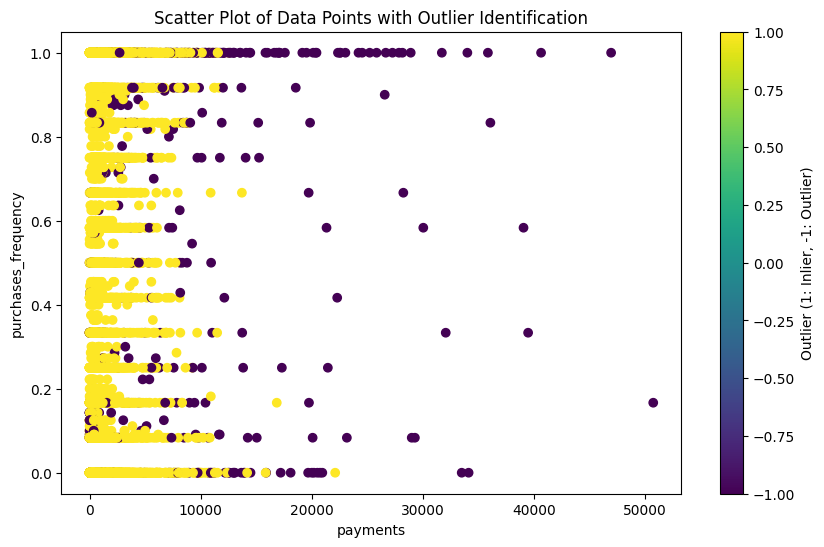

In [ ]:
# prompt: create a scatter plot to show dataframe using hau outliers column

import matplotlib.pyplot as plt

# Assuming 'df_with_outliers' is your DataFrame and 'outliers' is the column indicating outliers

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(df_with_outliers.payments, df_with_outliers['purchases_frequency'], c=df_with_outliers['outliers'], cmap='viridis') # Replace 'column_name' with an actual column
plt.xlabel("payments")
plt.ylabel("purchases_frequency") # Replace with the column name used for y-axis
plt.title("Scatter Plot of Data Points with Outlier Identification")
plt.colorbar(label='Outlier (1: Inlier, -1: Outlier)')
plt.show()

In [ ]:
# prompt: create a scatter plot to show dataframe using outliers column  with plotly

import plotly.express as px

fig = px.scatter(df_with_outliers, x="payments", y="purchases_frequency", color="outliers",
                 title="Scatter Plot of Data Points with Outlier Identification",
                 labels={"payments": "Payments", "purchases_frequency": "Purchases Frequency", "outliers": "Outlier"})
fig.show()

## Plotting to find out the best amount of clusters

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift


# Initialize lists to store silhouette scores
silhouette_s_kmeans = []
silhouette_s_dbscan = []
silhouette_s_gaussian = []
silhouette_s_agglomerative = []
silhouette_s_birch = []
silhouette_s_Kmean_stander = []
#silhouette_s_meanshift = []
#silhouette_s_spectral = []

# Loop through range of clusters from 2 to 10
for n_clusters in range(2, 11):
    kmeans_pipeline = Pipeline([
        ("scaler", MinMaxScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=42))
    ])
    dbscan_pipeline = Pipeline([
        ("scaler", MinMaxScaler()),
        ("cluster", DBSCAN())
    ])
    gaussian_mixture_pipeline = Pipeline([
        ("scaler", MinMaxScaler()),
        ("cluster", GaussianMixture(n_components=n_clusters, random_state=42))
    ])
    agglomerative_pipeline = Pipeline([
        ("scaler", MinMaxScaler()),
        ("cluster", AgglomerativeClustering(n_clusters=n_clusters))
    ])
    birch_pipeline = Pipeline([
        ("scaler", MinMaxScaler()),
        ("cluster", Birch(n_clusters=n_clusters))
    ])
    Kmean_stander_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=42))
    ])
    # spectral_pipeline = Pipeline([
    #     ("scaler", MinMaxScaler()),
    #     ("cluster", SpectralClustering(n_clusters=n_clusters, random_state=42))
    # ])

    # Fit and predict clusters for each algorithm
    kmeans_labels = kmeans_pipeline.fit_predict(df_train)
    dbscan_labels = dbscan_pipeline.fit_predict(df_train)
    gaussian_labels = gaussian_mixture_pipeline.fit_predict(df_train)
    agglomerative_labels = agglomerative_pipeline.fit_predict(df_train)
    birch_labels = birch_pipeline.fit_predict(df_train)
    Kmean_stander_pipeline_labels = Kmean_stander_pipeline.fit_predict(df_train)
    #spectral_labels = spectral_pipeline.fit_predict(df)

    print("still working", n_clusters)

    # Append silhouette scores
    silhouette_s_kmeans.append(silhouette_score(df_train, kmeans_labels))
    silhouette_s_dbscan.append(silhouette_score(df_train, dbscan_labels))
    silhouette_s_gaussian.append(silhouette_score(df_train, gaussian_labels))
    silhouette_s_agglomerative.append(silhouette_score(df_train, agglomerative_labels))
    silhouette_s_birch.append(silhouette_score(df_train, birch_labels))
    silhouette_s_Kmean_stander.append(silhouette_score(df_train, Kmean_stander_pipeline_labels))
    #silhouette_s_spectral.append(silhouette_score(df, spectral_labels))

# Plot the silhouette scores for comparison
plt.plot(range(2, 11), silhouette_s_kmeans, "o-", label="KMeans")
plt.plot(range(2, 11), silhouette_s_dbscan, "o-", label="DBSCAN")
plt.plot(range(2, 11), silhouette_s_gaussian, "o-", label="GaussianMixture")
plt.plot(range(2, 11), silhouette_s_agglomerative, "o-", label="Agglomerative")
plt.plot(range(2, 11), silhouette_s_birch, "o-", label="Birch")
plt.plot(range(2, 11), silhouette_s_Kmean_stander, "o-", label="Kmean_stander_pipeline_labels")
#plt.plot(range(2, 11), silhouette_s_spectral, "o-", label="SpectralClustering")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()


KeyboardInterrupt: 

For n_clusters = 2 The average silhouette_score is : 0.0546
For n_clusters = 3 The average silhouette_score is : -0.0378
For n_clusters = 4 The average silhouette_score is : -0.0363
For n_clusters = 5 The average silhouette_score is : 0.001
For n_clusters = 6 The average silhouette_score is : -0.023
For n_clusters = 7 The average silhouette_score is : -0.0301
For n_clusters = 8 The average silhouette_score is : -0.0229
For n_clusters = 9 The average silhouette_score is : -0.0201




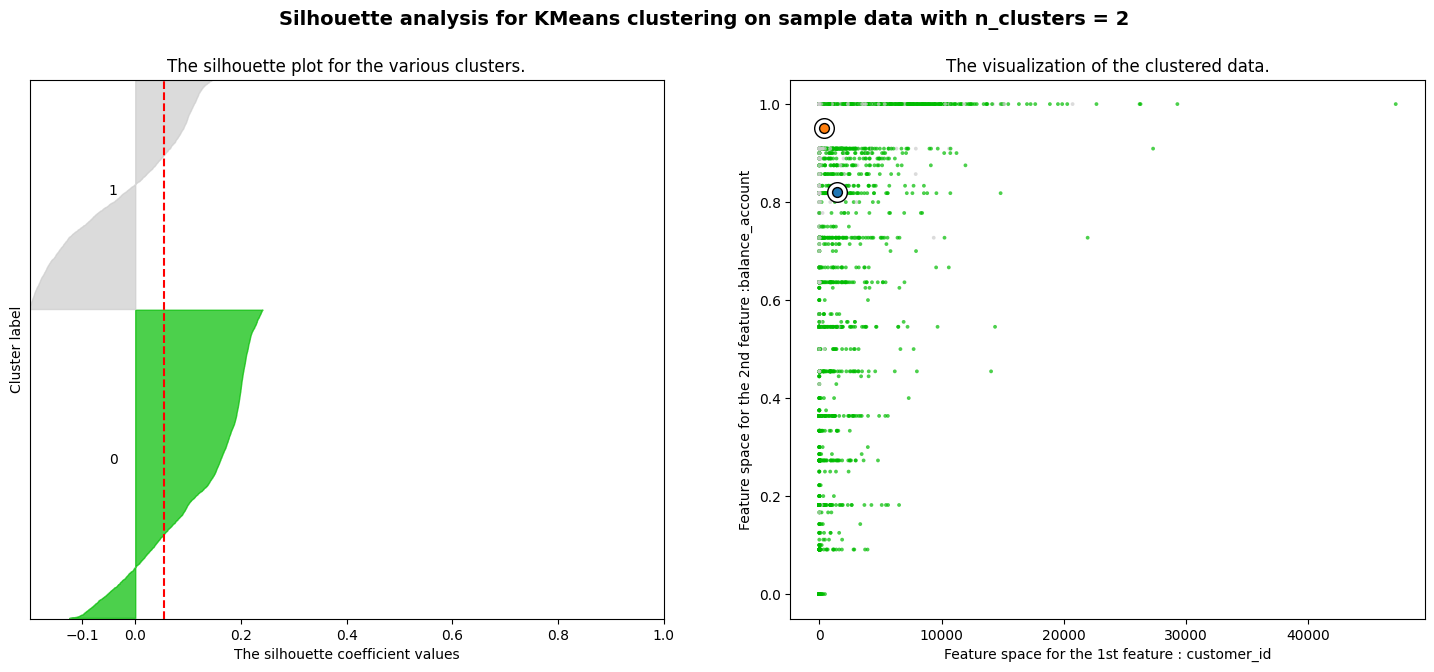

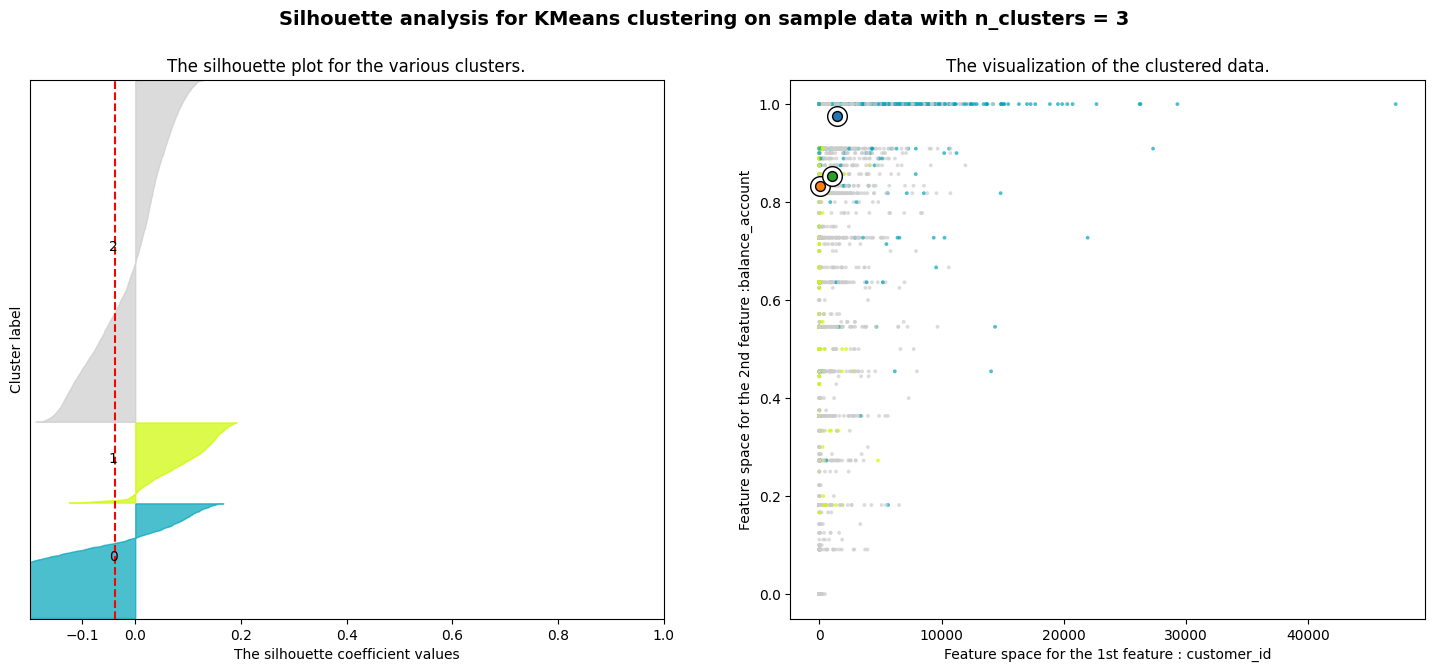

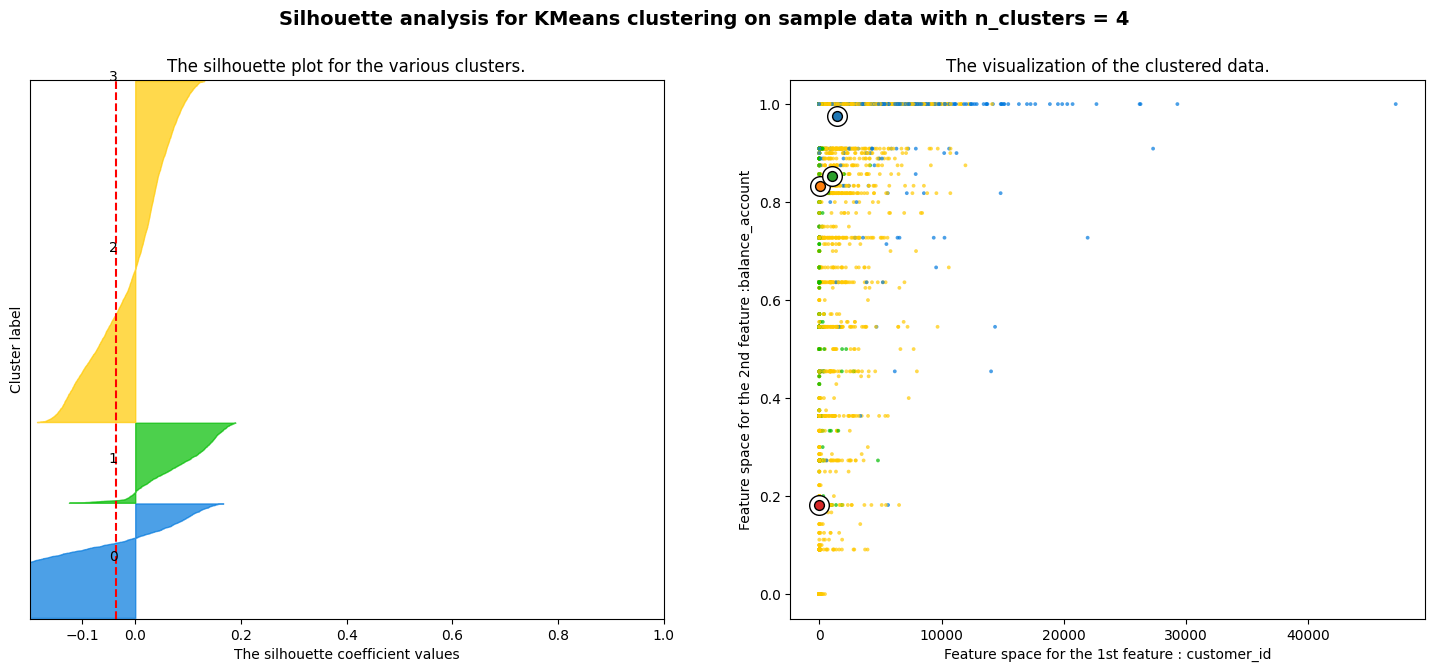

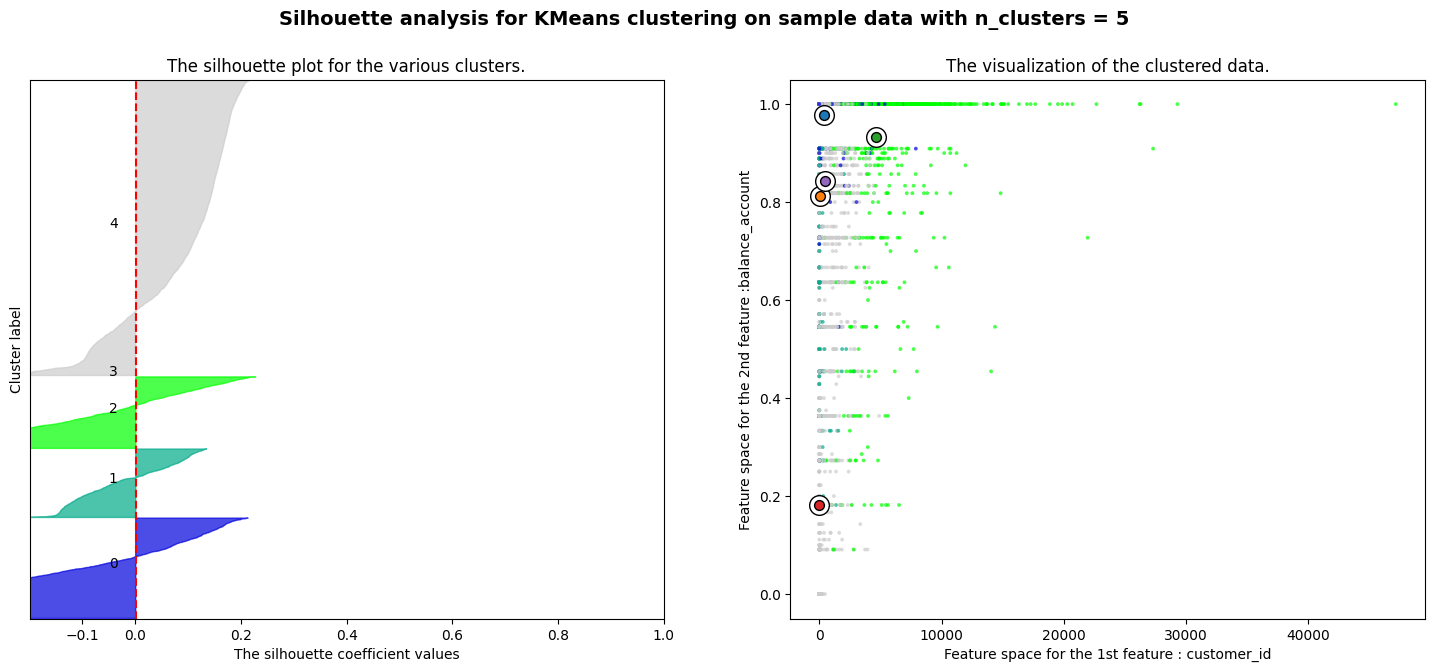

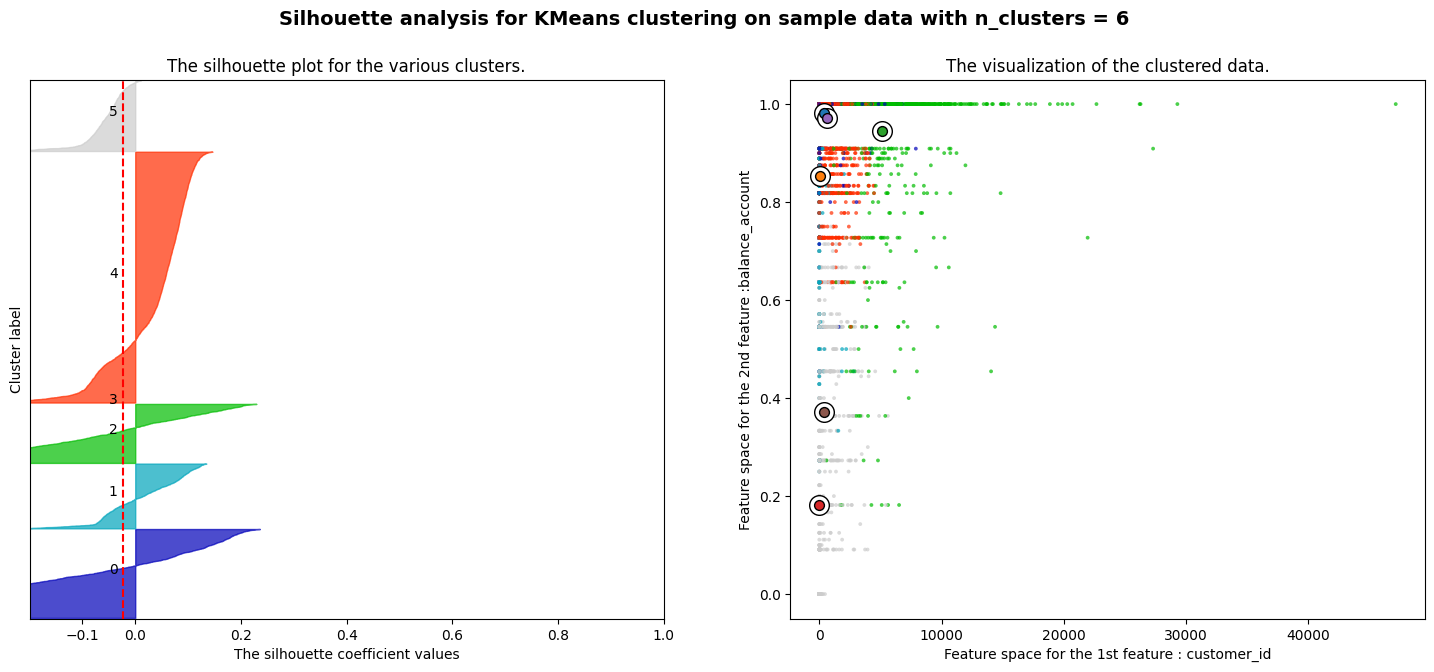

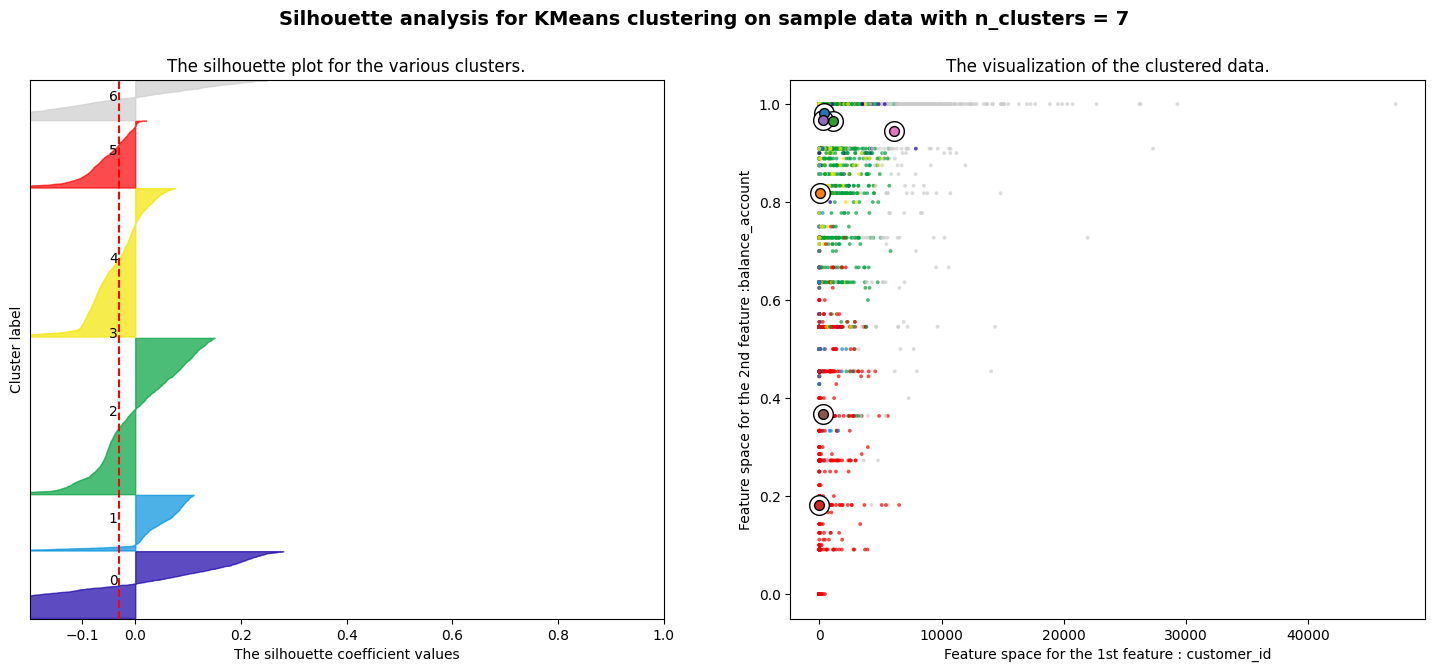

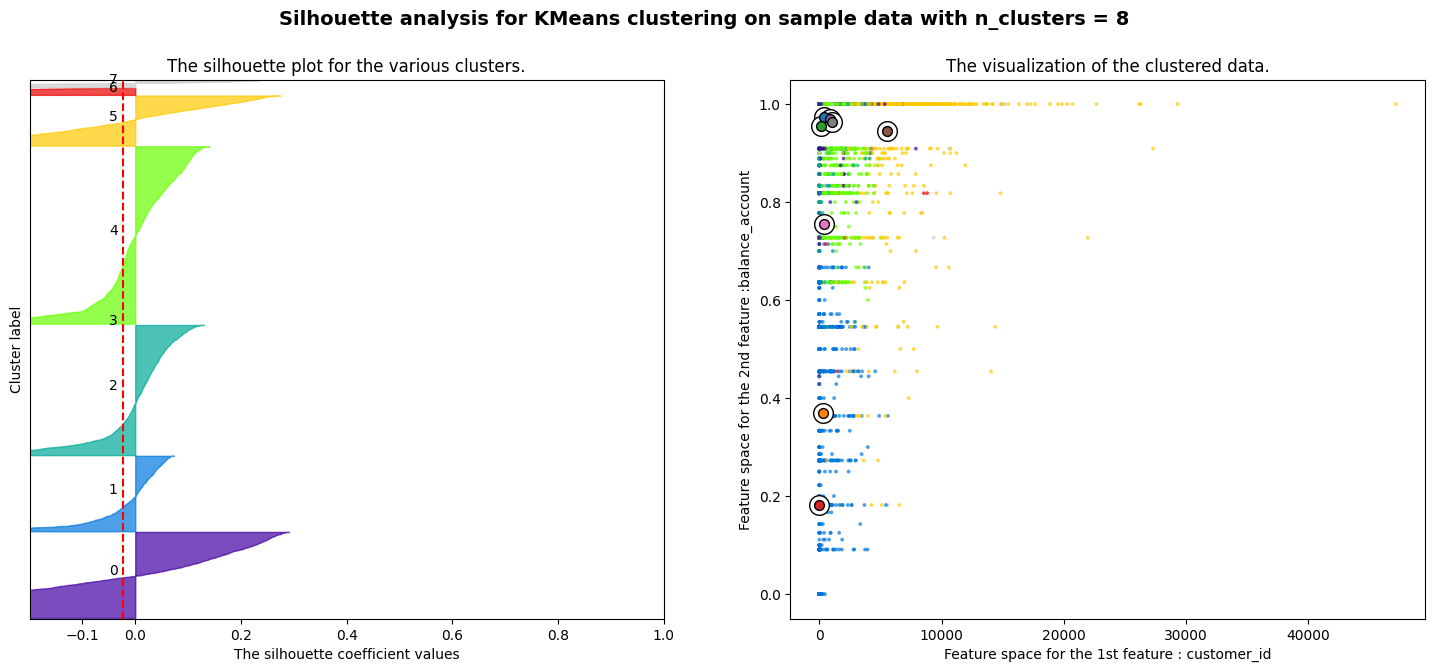

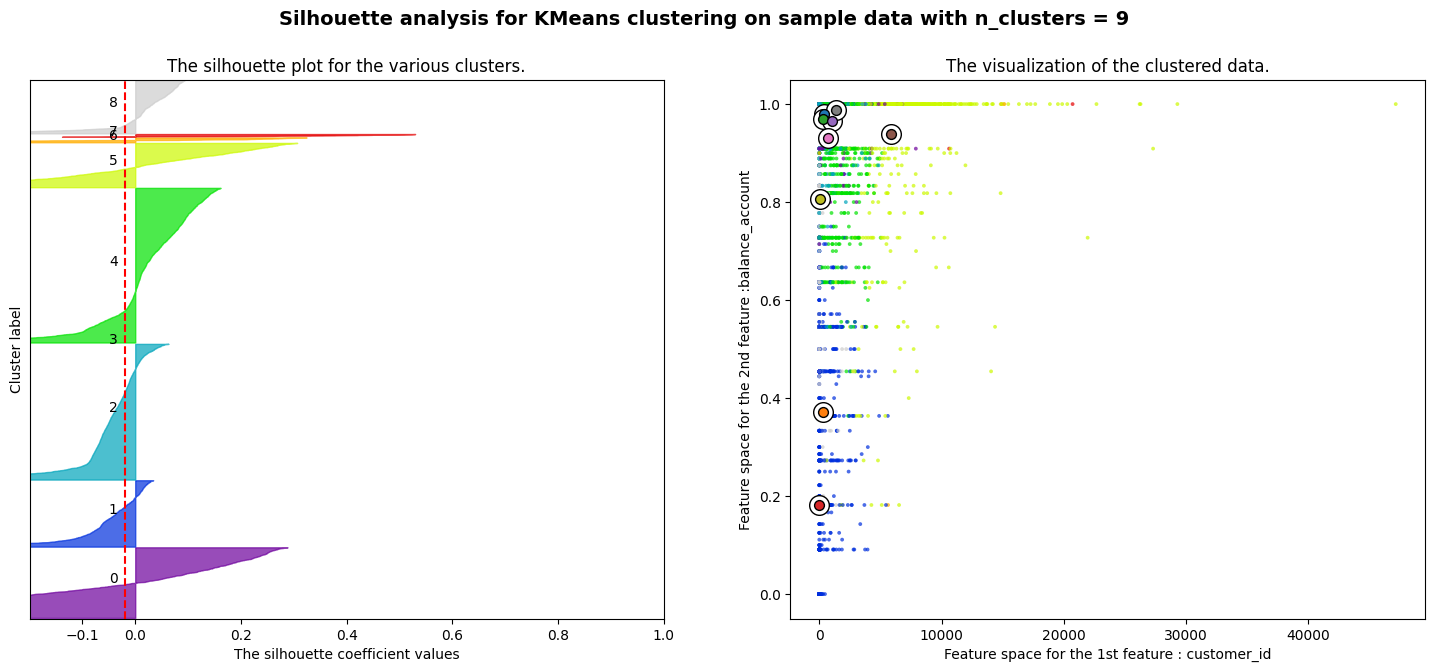

In [ ]:
X = df_train.to_numpy()

range_n_clusters = range(2, 10)

r_seed = 17

cols = df.columns

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg.round(4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(X[:, 0],
                X[:, 1],
                marker=".",
                s=30,
                lw=0,
                alpha=0.7,
                c=colors,
                edgecolor="k")

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
# Pipeline Definition: 1º) Scaling --> 2º) Model
pipe_pca = Pipeline([("scl", StandardScaler()), ("pca", pca)])
# Fit_transform:
customer_pca = pipe_pca.fit_transform(X)
pipe_pca.named_steps["pca"].explained_variance_ratio_



array([0.18909109, 0.16931394, 0.09880847, 0.08185201, 0.07741143,
       0.07350711, 0.06972764, 0.05727037, 0.05115373, 0.04518305,
       0.0364382 , 0.03076067, 0.01948229])

In [ ]:
evr = np.cumsum(pipe_pca.named_steps["pca"].explained_variance_ratio_)
evr
# Finding out the interceptor that represents 95% of the total variance:
x_intercept = np.argmax(evr > 0.95) #evr is an array of the cumulative variances
print('The interceptor is located at component: ', x_intercept)

The interceptor is located at component:  11


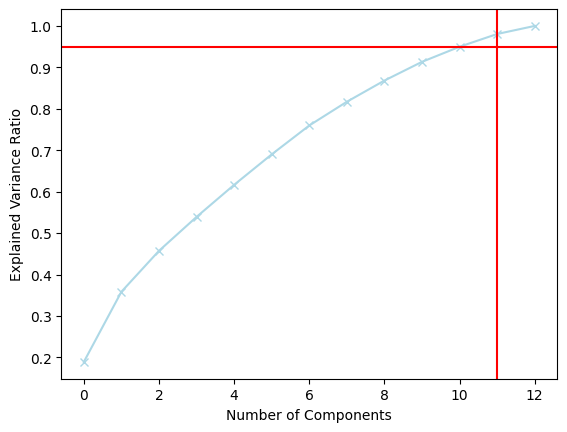

In [ ]:
# Ploting the location of the interceptor:

plt.plot(evr, "-x", color="lightblue") #plotting the cumulative sum of variance, so we can where the variance increases are not as pronounced
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.axvline(x=x_intercept, color="red") #vertical line to see the number of components that corresponds to the 95% total variance
plt.axhline(y=0.95, color="red") #horizontal line for 95% of the total variance

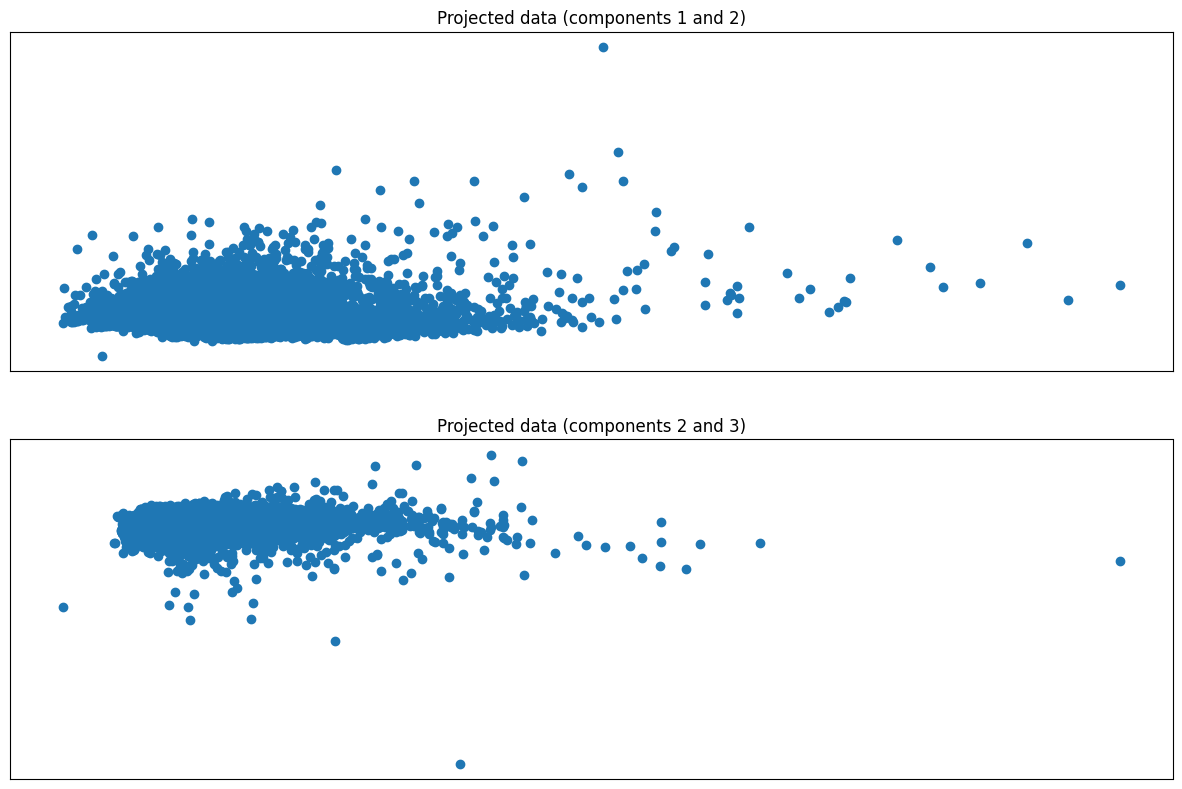

In [ ]:
#After dimensionality reduction, we can use gene_pca plot the principal components

plt.rcParams["figure.figsize"] = (15, 15)

fig = plt.figure()

# # plot original roll
# ax = fig.add_subplot(311, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
# ax.set_title("Original data")

# plot projected roll (components 1 and 2)
ax = fig.add_subplot(311)
ax.scatter(customer_pca[:, 0], customer_pca[:, 1],  cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data (components 1 and 2)')

# plot projected roll (components 2 and 3)
ax = fig.add_subplot(312)
ax.scatter(customer_pca[:, 1], customer_pca[:, 2],cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data (components 2 and 3)')
plt.show()


# # plot projected roll (components 1 and 3)
# ax = fig.add_subplot(313)
# ax.scatter(gene_pca[:, 2], gene_pca[:, 3],cmap=plt.cm.Spectral)
# plt.axis('tight')
# plt.xticks([]), plt.yticks([])
# plt.title('Projected data (components 1 and 3)')
# plt.show()

plt.show()

In [ ]:
pipe_pre_PCA = Pipeline(
        [
            ("scl", StandardScaler()),
            ("pca", PCA(2)),]
    )

In [ ]:
reduced_data = pipe_pre_PCA.fit_transform(X)

In [ ]:
reduced_df = pd.DataFrame(reduced_data)

In [ ]:
r_seed = 42  # random seed to use during modeling for reproducibility
cluster_errors = []

for i in range(1, 14):
    n_clusters = i
    pipe_pca_kmean = Pipeline(
        [
            ("scl", StandardScaler()),
            ("pca", PCA(2)),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))]
    )

    pipe_pca_kmean.fit(X)
    pipe_pca_kmean.predict(X)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

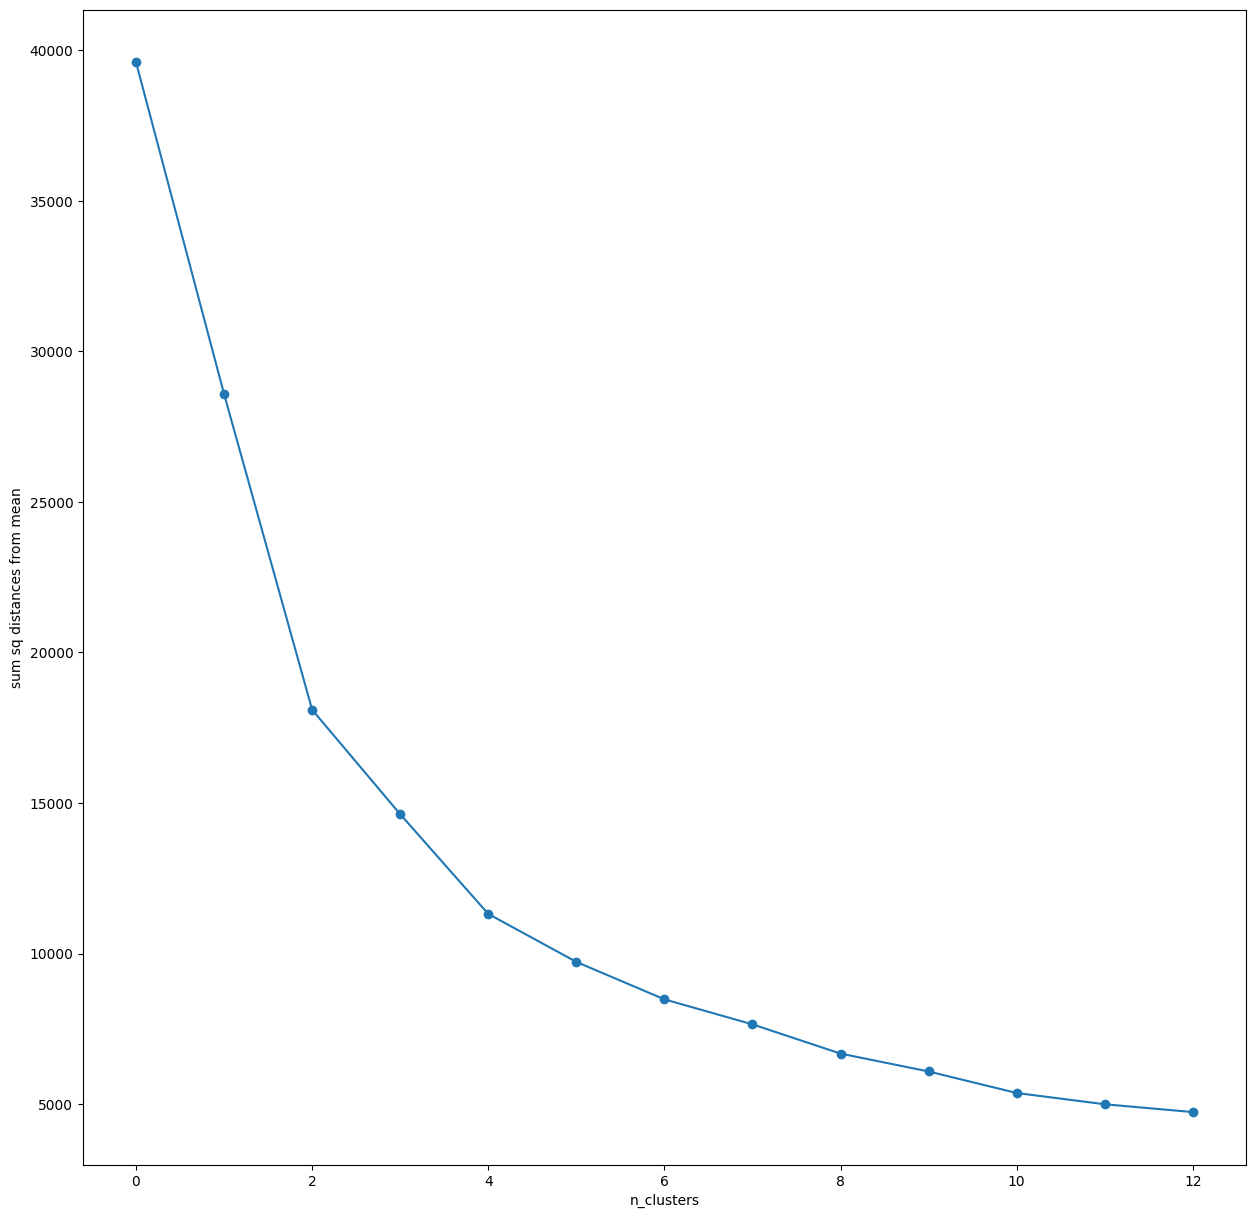

In [ ]:
plt.clf()
plt.plot(cluster_errors, "o-")
plt.xlabel("n_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [ ]:
pipe_pca_kmean = Pipeline(
        [
            ("scl", StandardScaler()),
            ("pca", PCA(2)),
            ("cluster", KMeans(n_clusters=4, random_state=r_seed, verbose=0))]
    )

In [ ]:
# Fit:
pipe_pca_kmean.fit(X)

Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA(n_components=2)),
                ('cluster', KMeans(n_clusters=4, random_state=42))])

In [ ]:
customers_kmean_cluster = pd.DataFrame(
    data = pipe_pca_kmean.named_steps["cluster"].labels_,
    index =df_train.index,
    columns=['kmean_cluster']
)

In [ ]:
customers_kmean_cluster.shape

(8500, 1)

In [ ]:
df_train['kmean_cluster']=pipe_pca_kmean.named_steps["cluster"].labels_

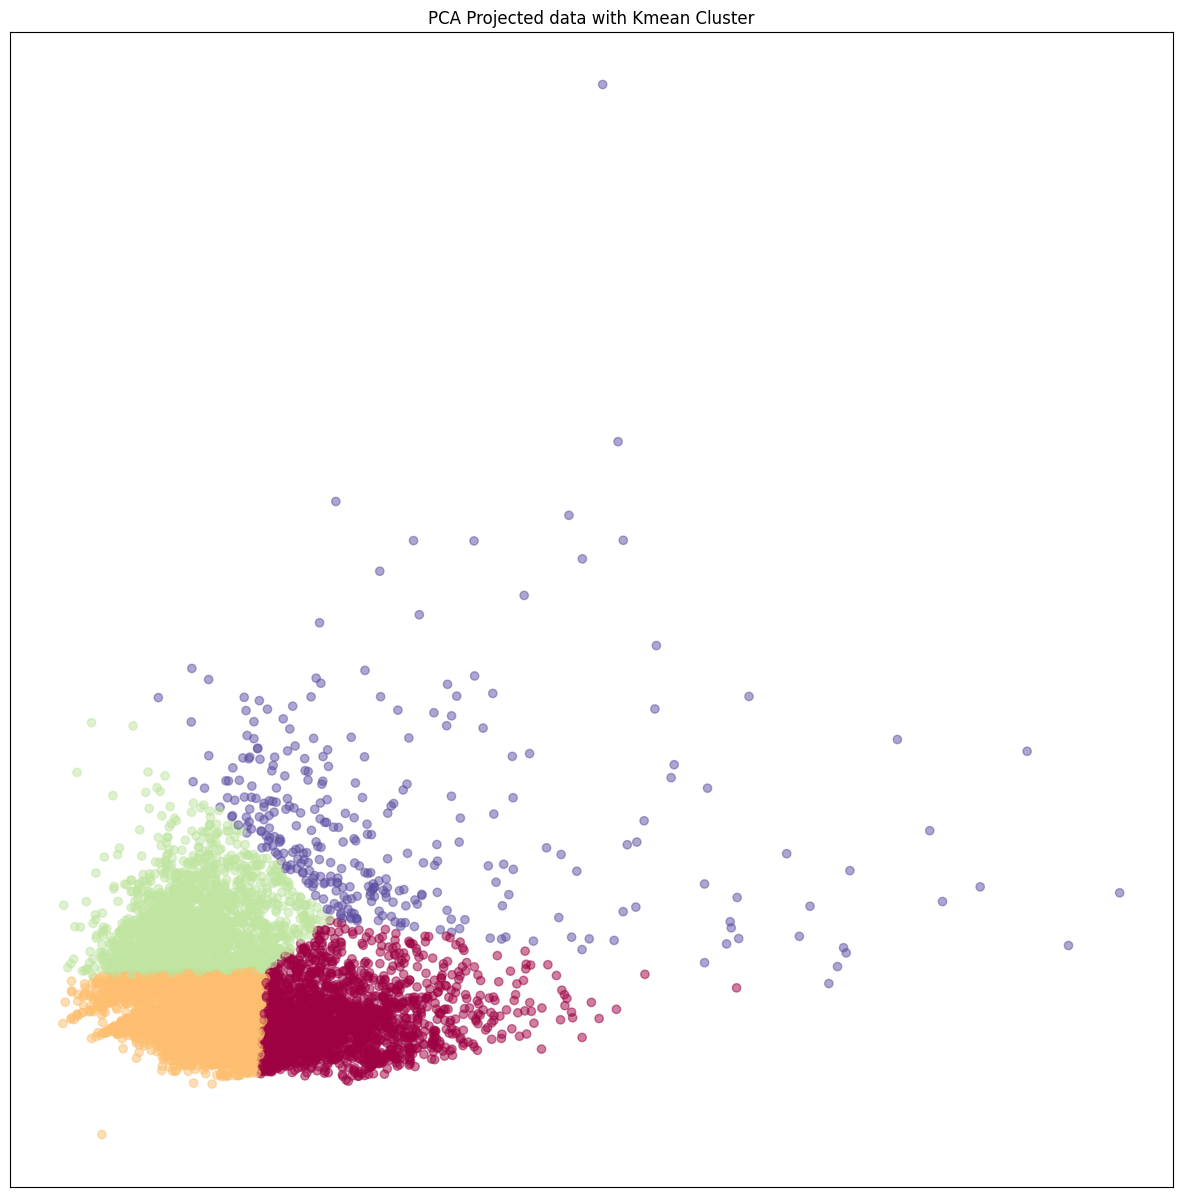

In [ ]:
fig = plt.figure()

ax = fig.add_subplot()
# Access the data using .iloc or .loc instead of [:, 0]
ax.scatter(reduced_df.iloc[:, 0], reduced_df.iloc[:, 1], c=df_train['kmean_cluster'], alpha=0.5, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('PCA Projected data with Kmean Cluster')
plt.show()

In [ ]:
df_train.groupby('kmean_cluster')['paid_advance'].count()

kmean_cluster
0    2120
1    3977
2    2088
3     315
Name: paid_advance, dtype: int64

In [ ]:
reduced_df.to_csv("reduced_df.csv", index=False)

For n_clusters = 2 The average silhouette_score is : 0.3576
For n_clusters = 3 The average silhouette_score is : 0.4094
For n_clusters = 4 The average silhouette_score is : 0.3757
For n_clusters = 5 The average silhouette_score is : 0.3748
For n_clusters = 6 The average silhouette_score is : 0.3795
For n_clusters = 7 The average silhouette_score is : 0.3757
For n_clusters = 8 The average silhouette_score is : 0.3561
For n_clusters = 9 The average silhouette_score is : 0.3379




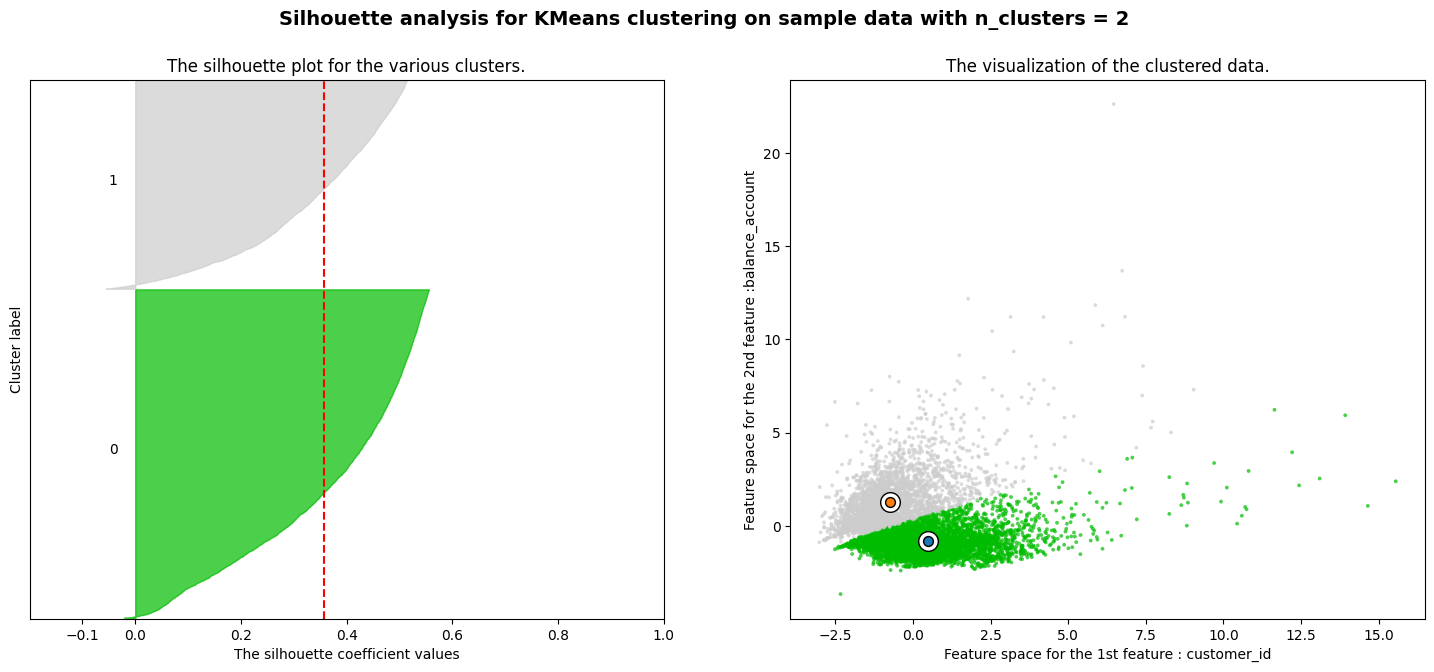

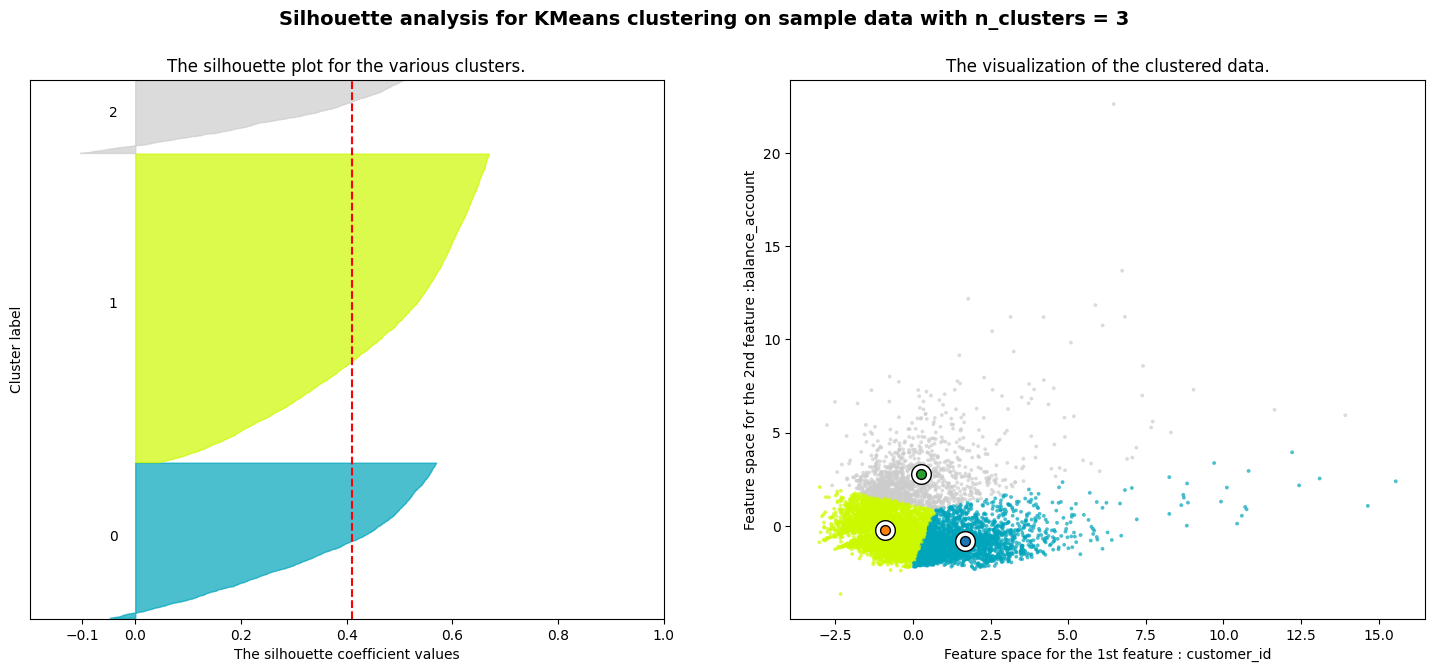

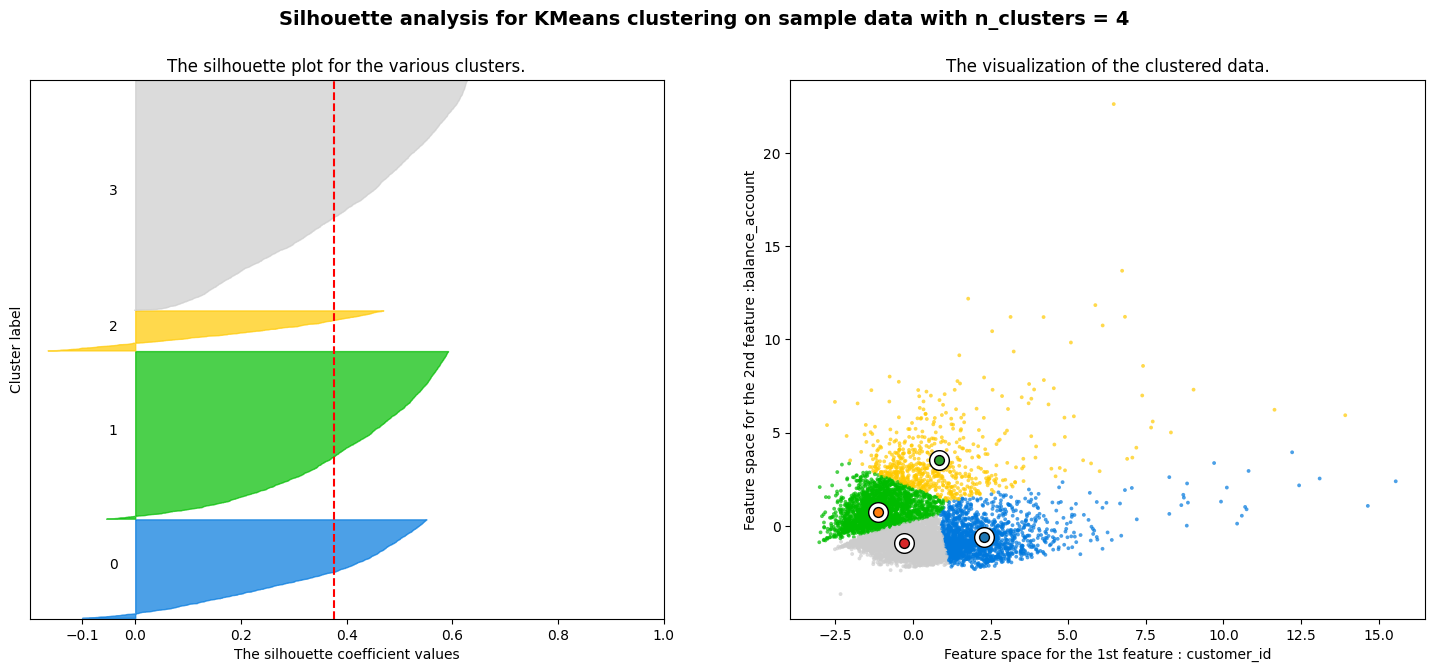

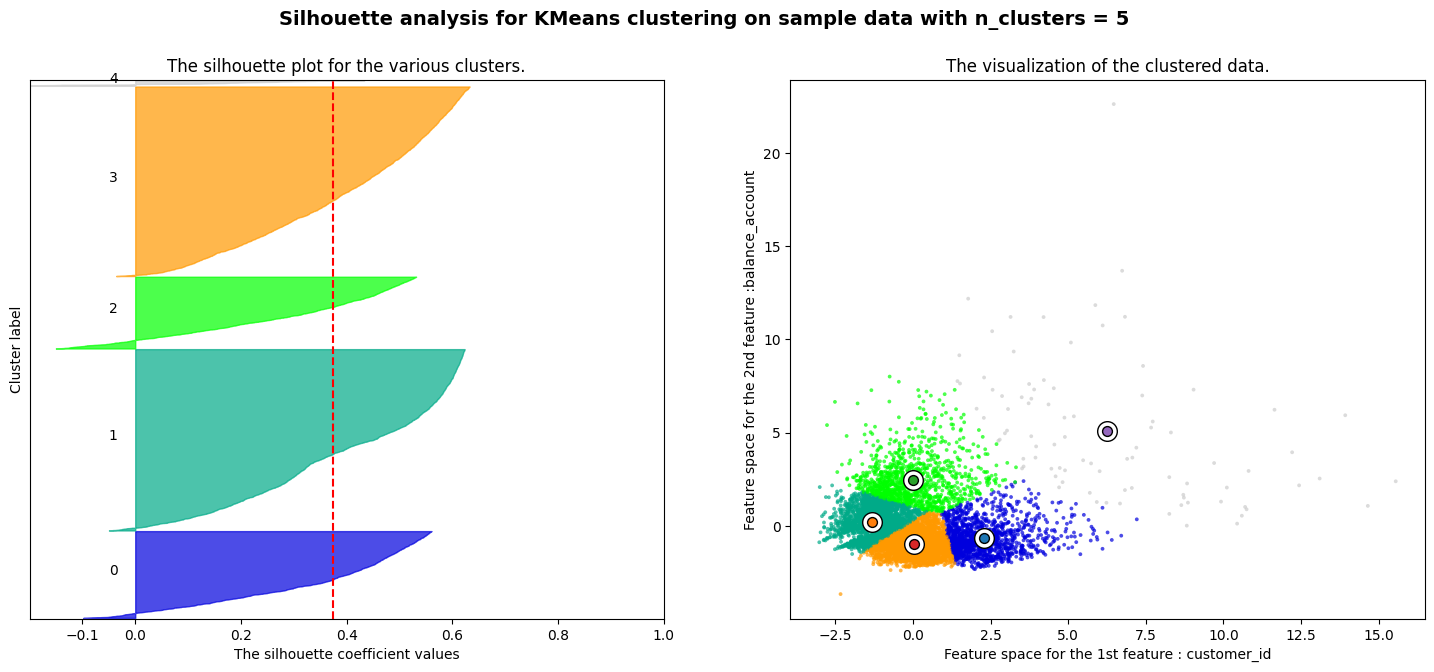

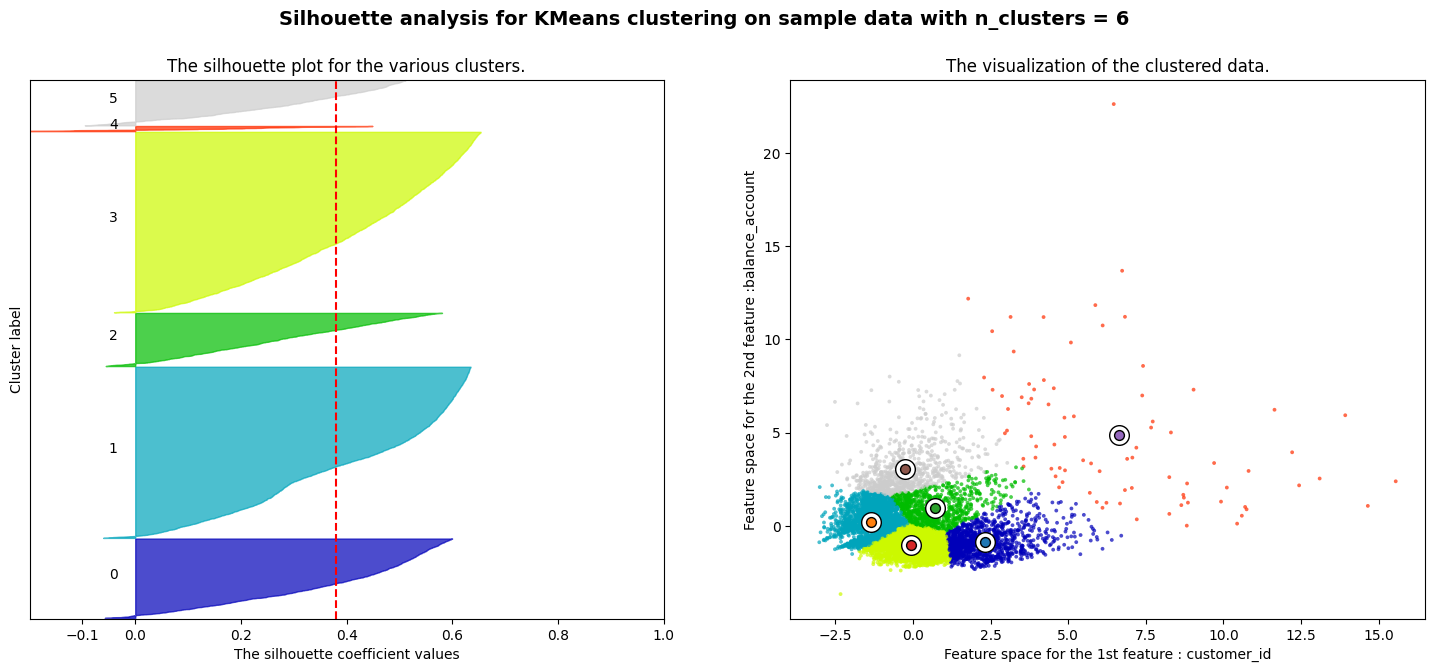

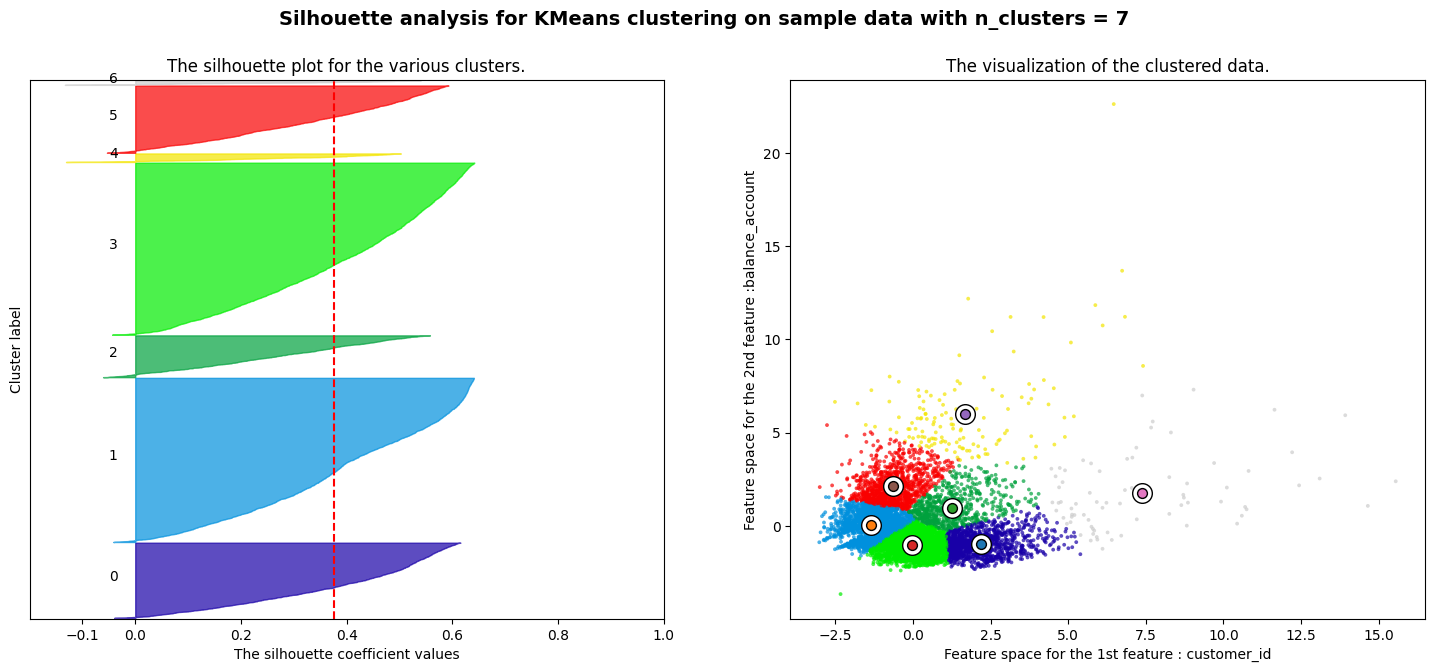

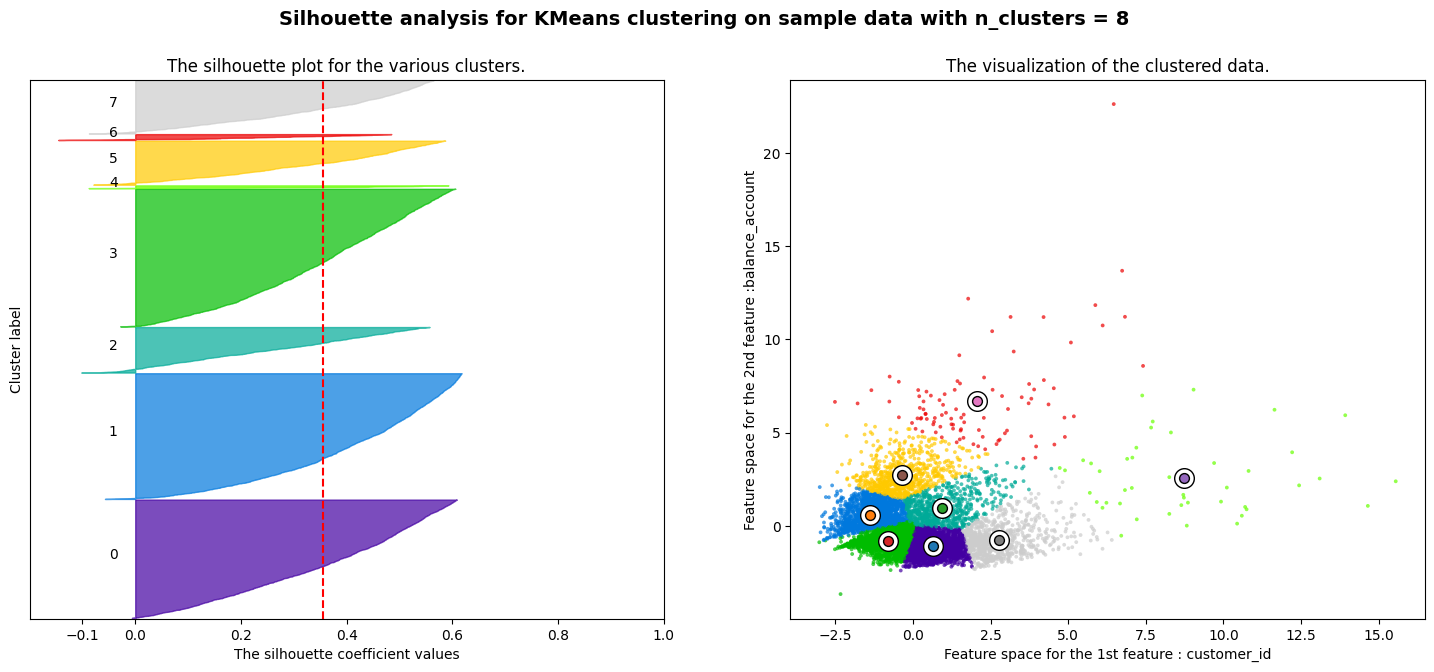

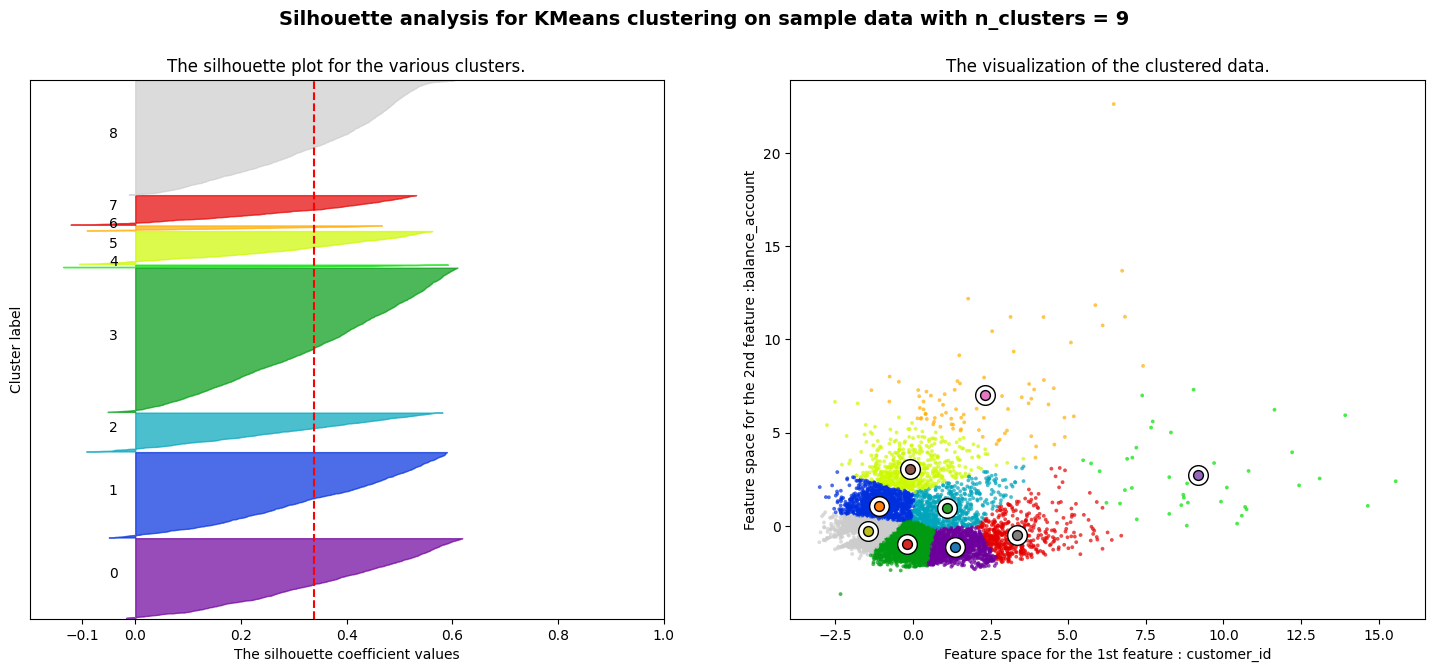

In [ ]:
X = reduced_df.to_numpy()

range_n_clusters = range(2, 10)

r_seed = 17

cols = df.columns

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg.round(4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(X[:, 0],
                X[:, 1],
                marker=".",
                s=30,
                lw=0,
                alpha=0.7,
                c=colors,
                edgecolor="k")

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.show()

In [ ]:
cluster0=df_train[df_train['kmean_cluster']==0]
cluster1=df_train[df_train['kmean_cluster']==1]
cluster2=df_train[df_train['kmean_cluster']==2]
cluster3=df_train[df_train['kmean_cluster']==3]

In [ ]:
cluster0.describe()


paid_advance  balance_frequency_update  installments  \
count   2120.000000               2120.000000   2120.000000   
mean     219.157351                  0.965325    980.119075   
std      640.115635                  0.105572   1063.481551   
min        0.000000                  0.000000      0.000000   
25%        0.000000                  1.000000    219.562500   
50%        0.000000                  1.000000    706.060000   
75%        0.000000                  1.000000   1390.027500   
max     7894.578816                  1.000000   8391.550000   

       purchases_frequency  full_purchases_frequency  credit_limit  \
count          2120.000000               2120.000000   2120.000000   
mean              0.903297                  0.522271   6262.655232   
std               0.161056                  0.369148   3838.669085   
min               0.083333                  0.000000    300.000000   
25%               0.833333                  0.166667   3000.000000   
50%               1.000000                  0.583333   6000.000000   
75%               1.000000                  0.916667   8500.000000   
max               1.000000                  1.000000  25000.000000   

       fixed_rate_period      payments  min_payments  full_payment_prc  \
count        2120.000000   2120.000000   2120.000000       2120.000000   
mean           11.860849   2328.416582    649.554847          0.329878   
std             0.684194   2089.604455   1071.348110          0.390254   
min             6.000000      0.000000      0.261984          0.000000   
25%            12.000000    983.546472    173.318676          0.000000   
50%            12.000000   1692.921857    224.411031          0.083333   
75%            12.000000   2947.305115    695.103812          0.727273   
max            12.000000  17005.409690  18959.869380          1.000000   

       Avg_Purchase_Amount  Cash_Advance_Ratio  Purchase_to_Balance_Ratio  \
count          2120.000000         2120.000000                2120.000000   
mean             92.539442            3.448049                   9.265477   
std             145.226572            7.394436                  69.188113   
min               0.700000            0.000000                   0.000000   
25%              42.404500            0.000000                   1.067245   
50%              63.094862            0.000000                   4.676335   
75%              98.948974            0.000000                  10.217358   
max            2900.000000           46.000000                2870.452293   

       kmean_cluster  
count         2120.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0

In [ ]:
df_with_outliers.shape

(8500, 14)

In [ ]:
df_without_outliers=df_with_outliers[df_with_outliers['outliers']==1]
df_without_outliers.shape

(8075, 14)

In [ ]:
reduced_data2 = pipe_pre_PCA.fit_transform(df_without_outliers)

In [ ]:
r_seed = 42  # random seed to use during modeling for reproducibility
cluster_errors = []

for i in range(1, 14):
    n_clusters = i
    pipe_pca_kmean = Pipeline(
        [
            ("scl", StandardScaler()),
            ("pca", PCA(2)),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))]
    )

    pipe_pca_kmean.fit(df_without_outliers)
    pipe_pca_kmean.predict(df_without_outliers)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

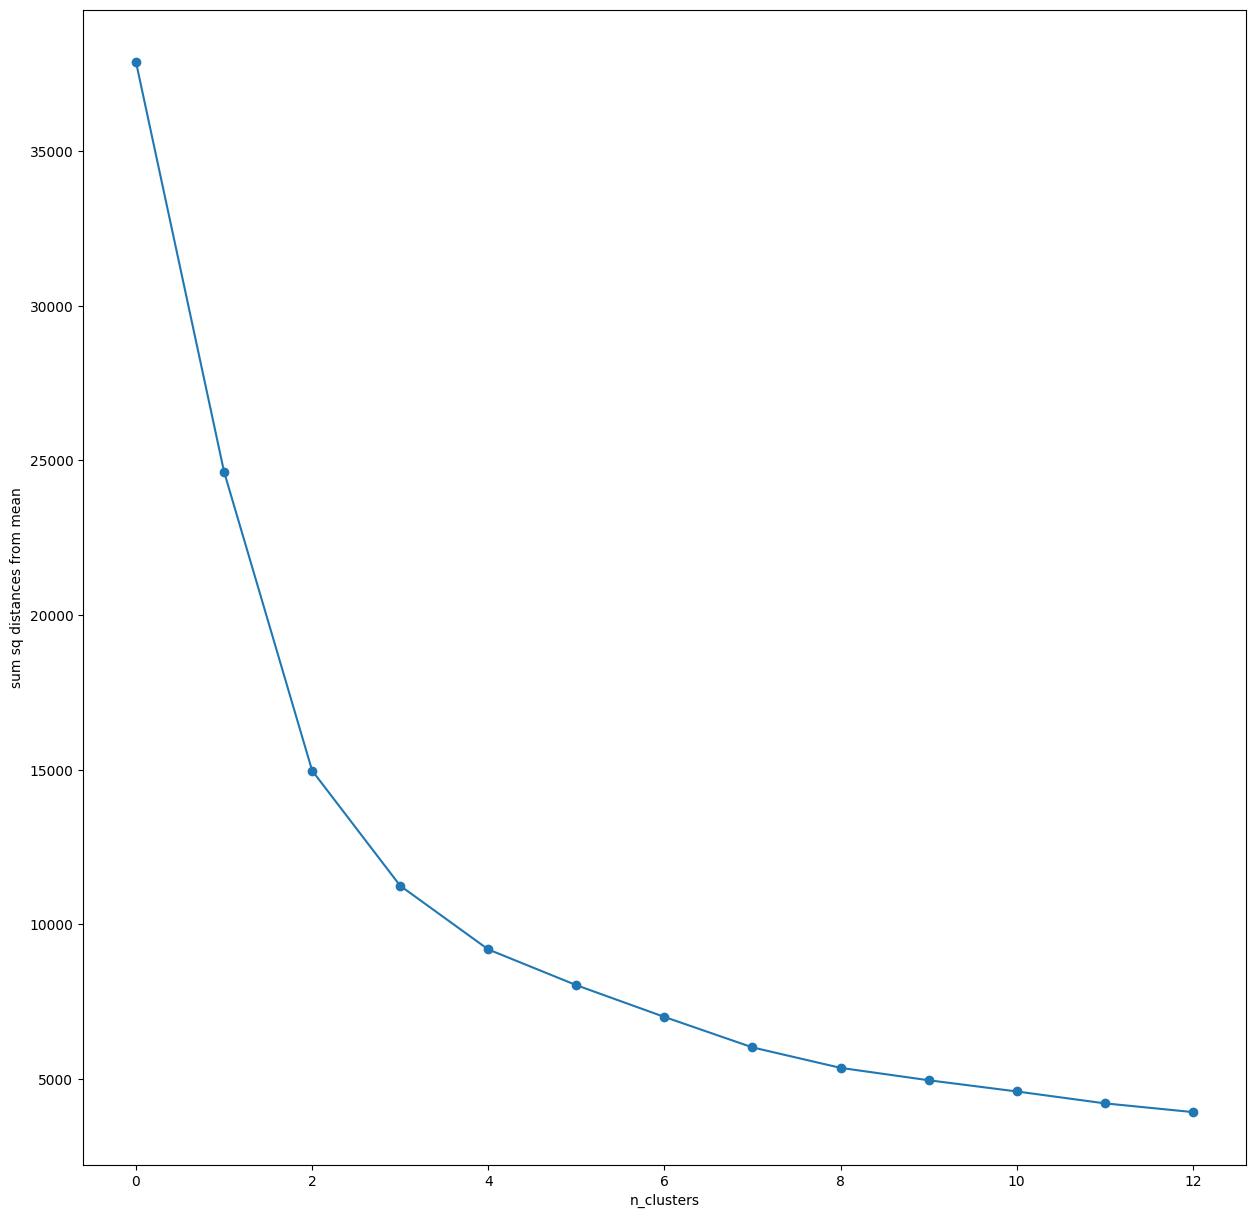

In [ ]:
plt.clf()
plt.plot(cluster_errors, "o-")
plt.xlabel("n_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.379
For n_clusters = 3 The average silhouette_score is : 0.4042
For n_clusters = 4 The average silhouette_score is : 0.3709
For n_clusters = 5 The average silhouette_score is : 0.3477
For n_clusters = 6 The average silhouette_score is : 0.3552
For n_clusters = 7 The average silhouette_score is : 0.3448
For n_clusters = 8 The average silhouette_score is : 0.3476
For n_clusters = 9 The average silhouette_score is : 0.3246




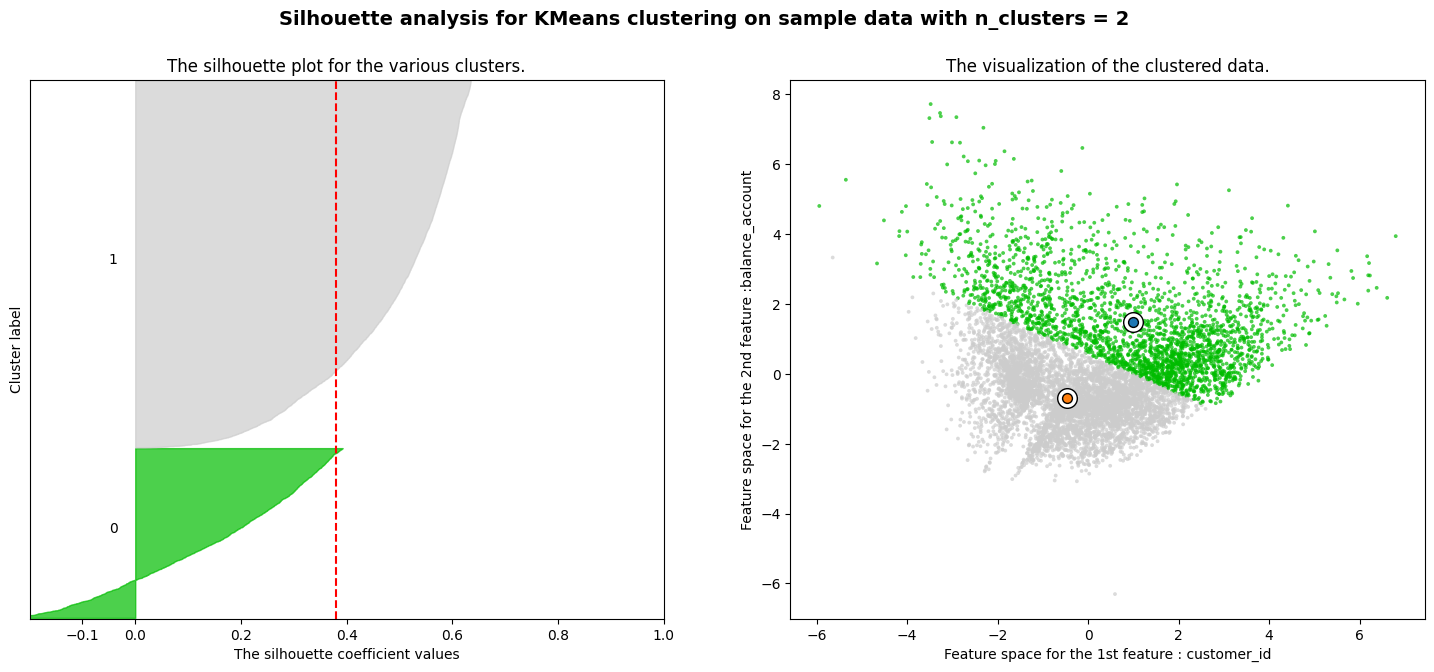

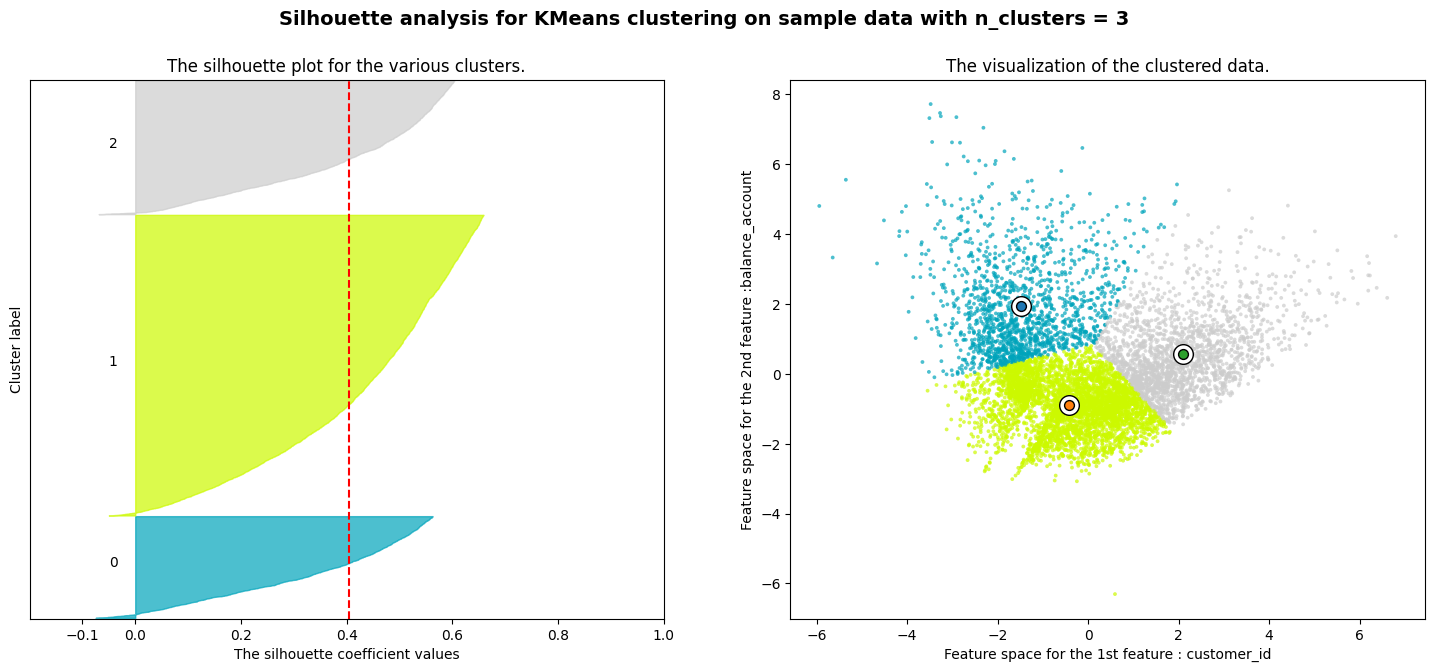

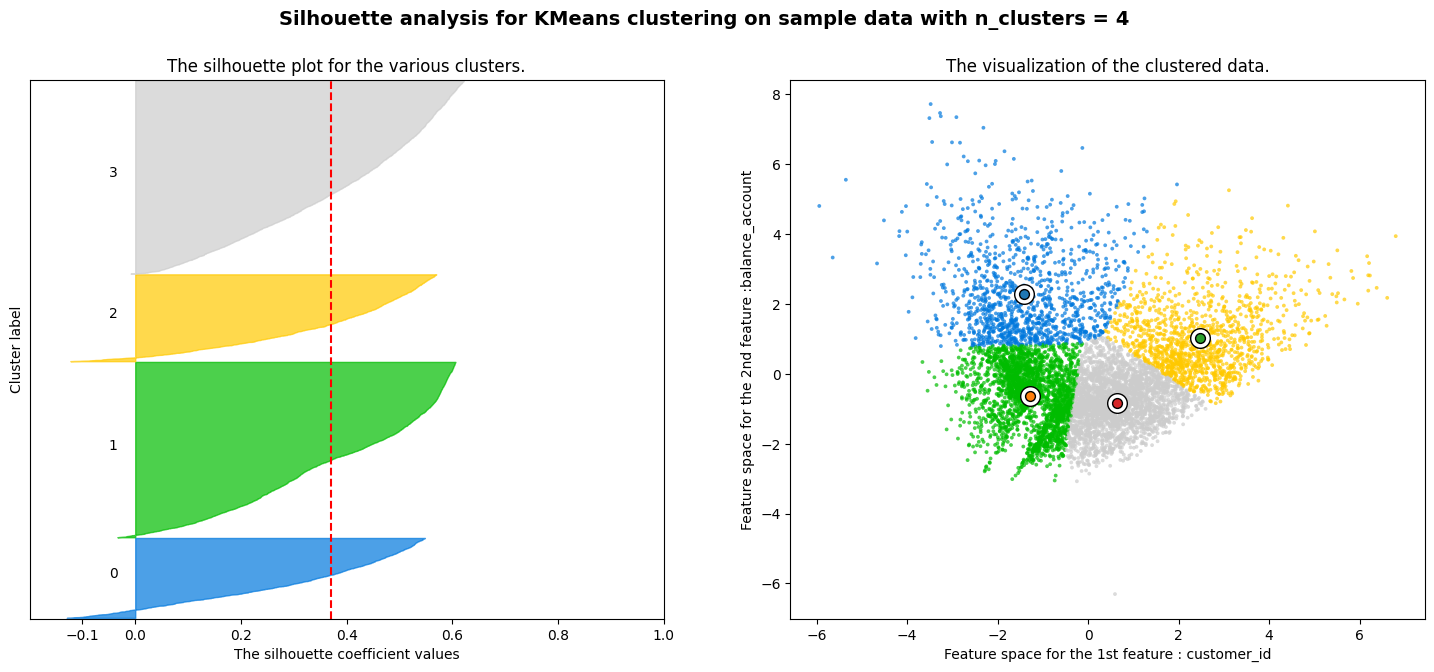

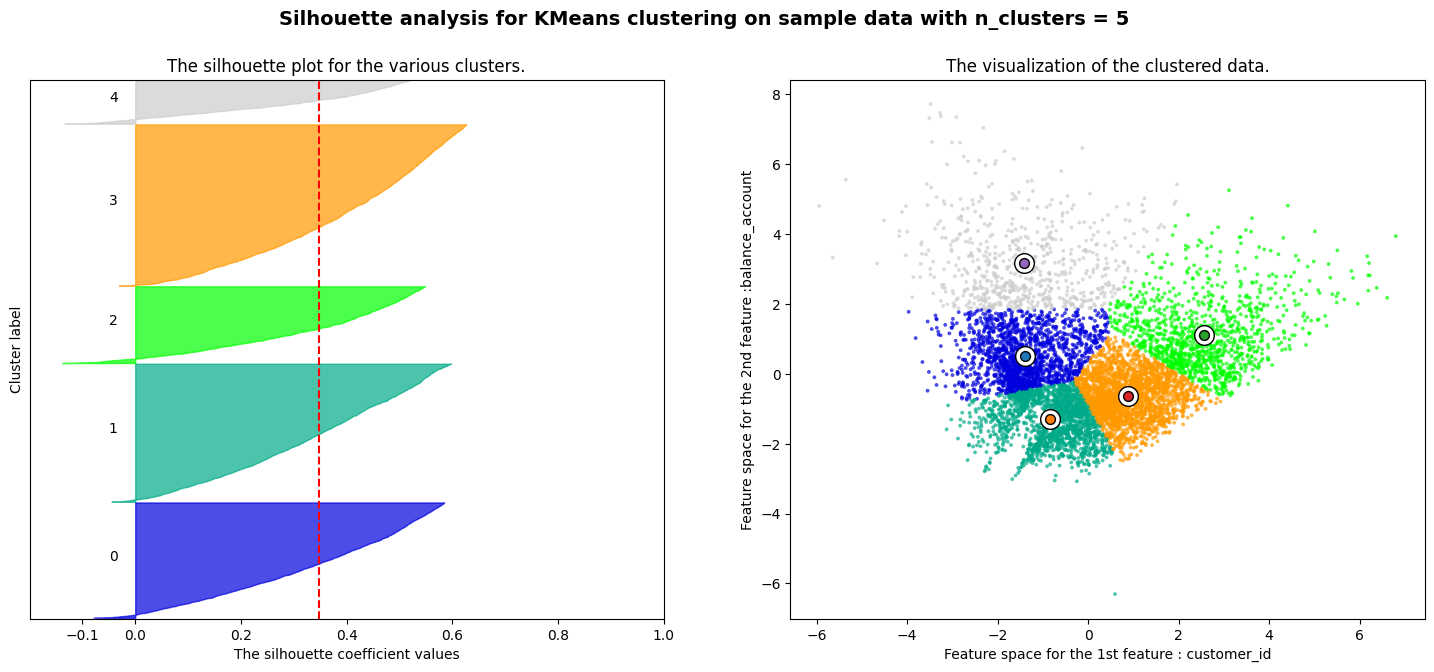

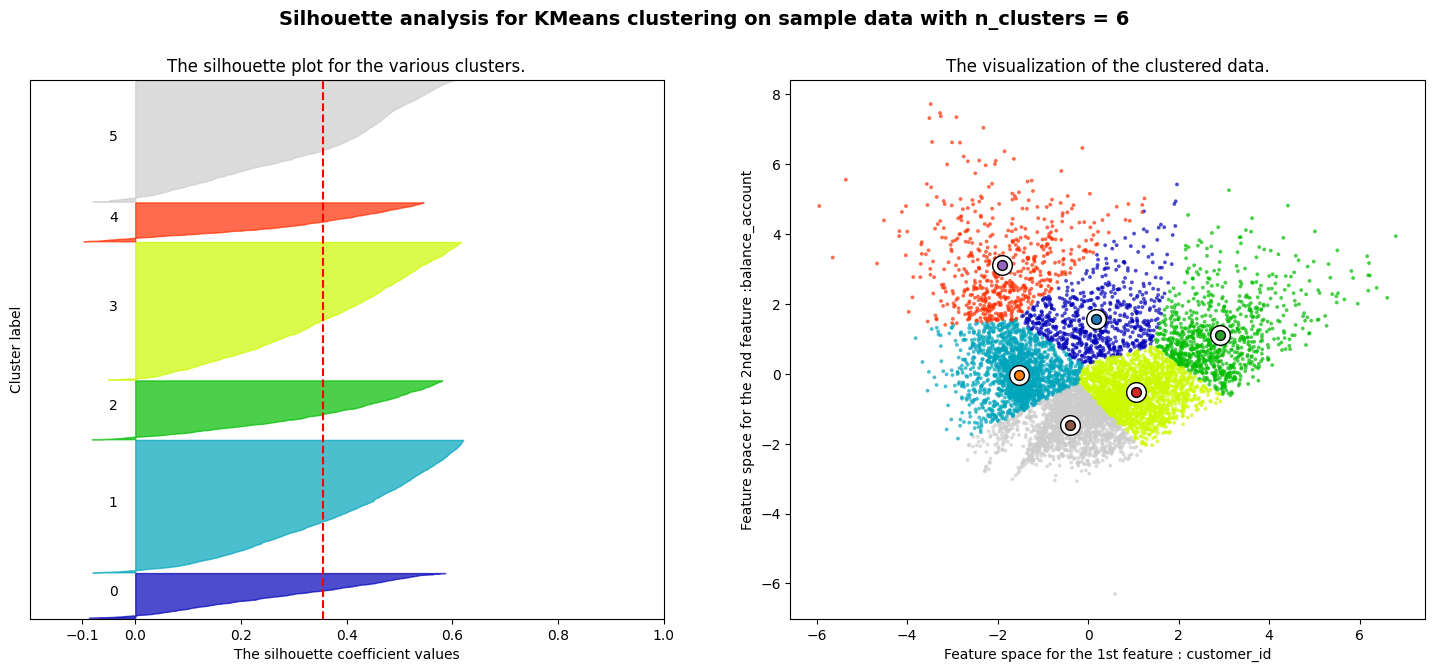

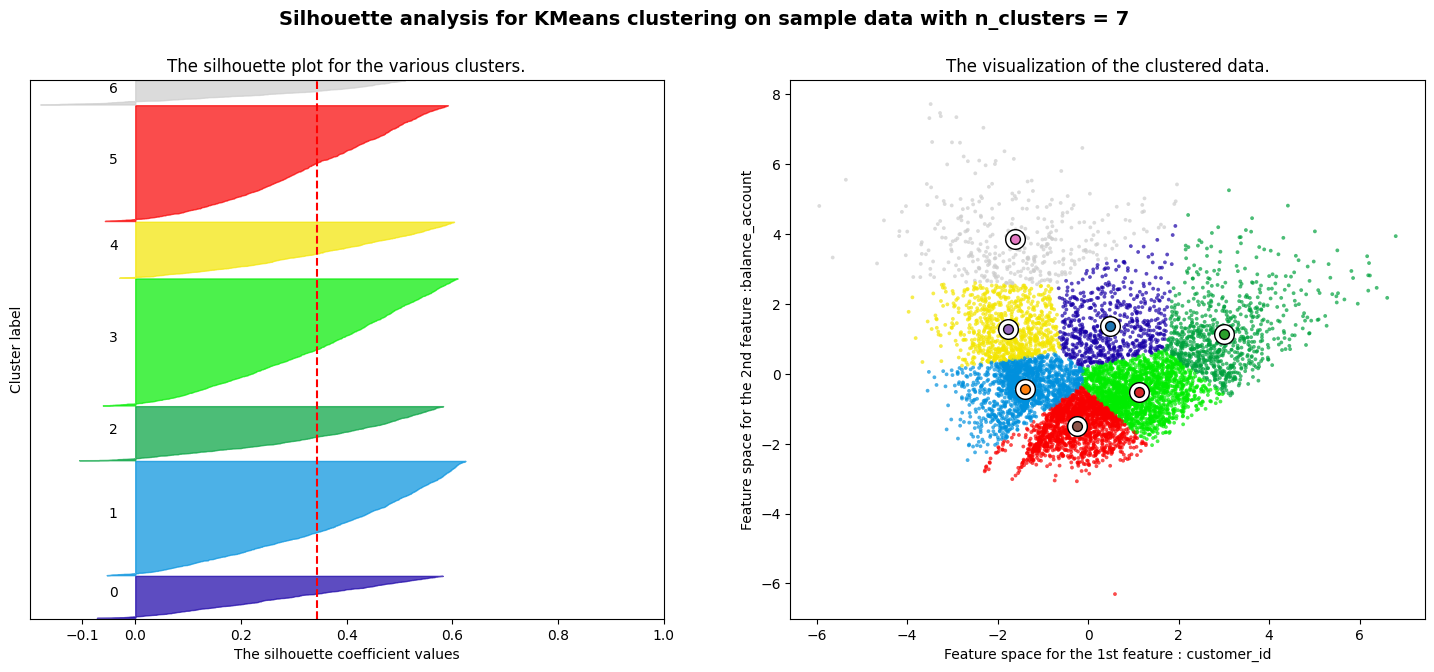

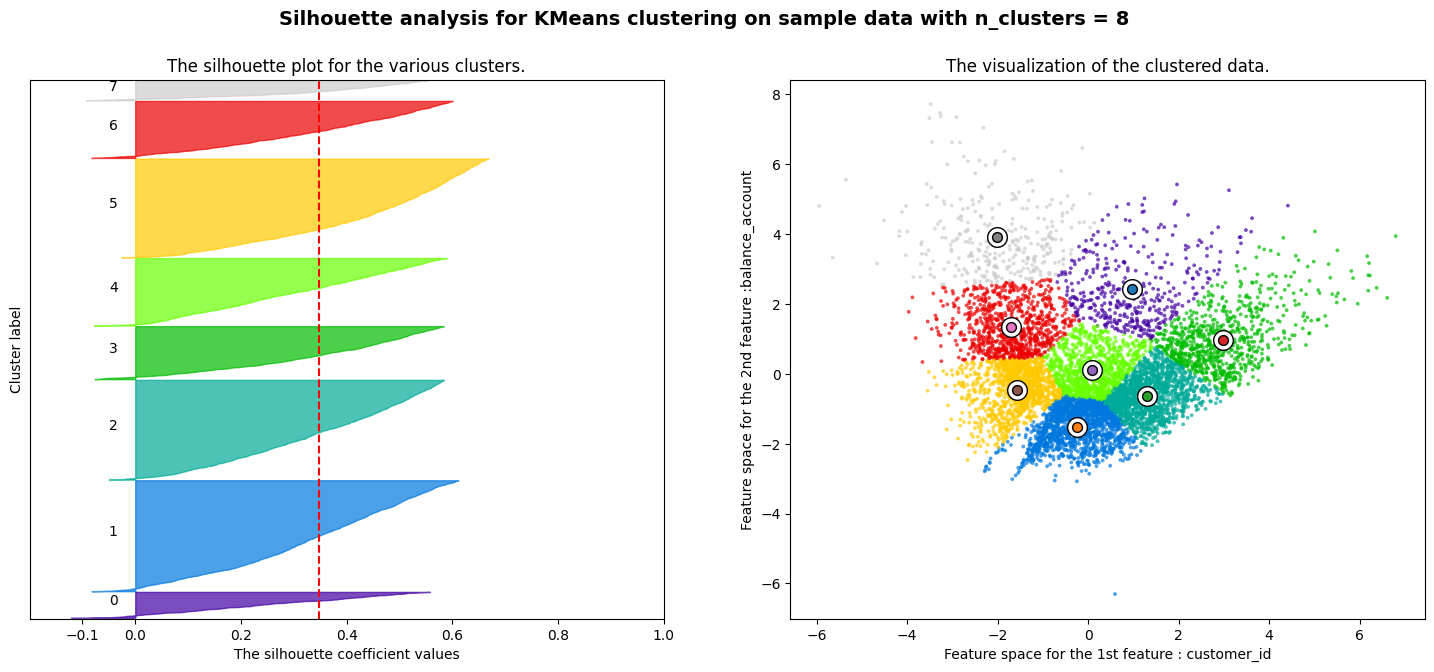

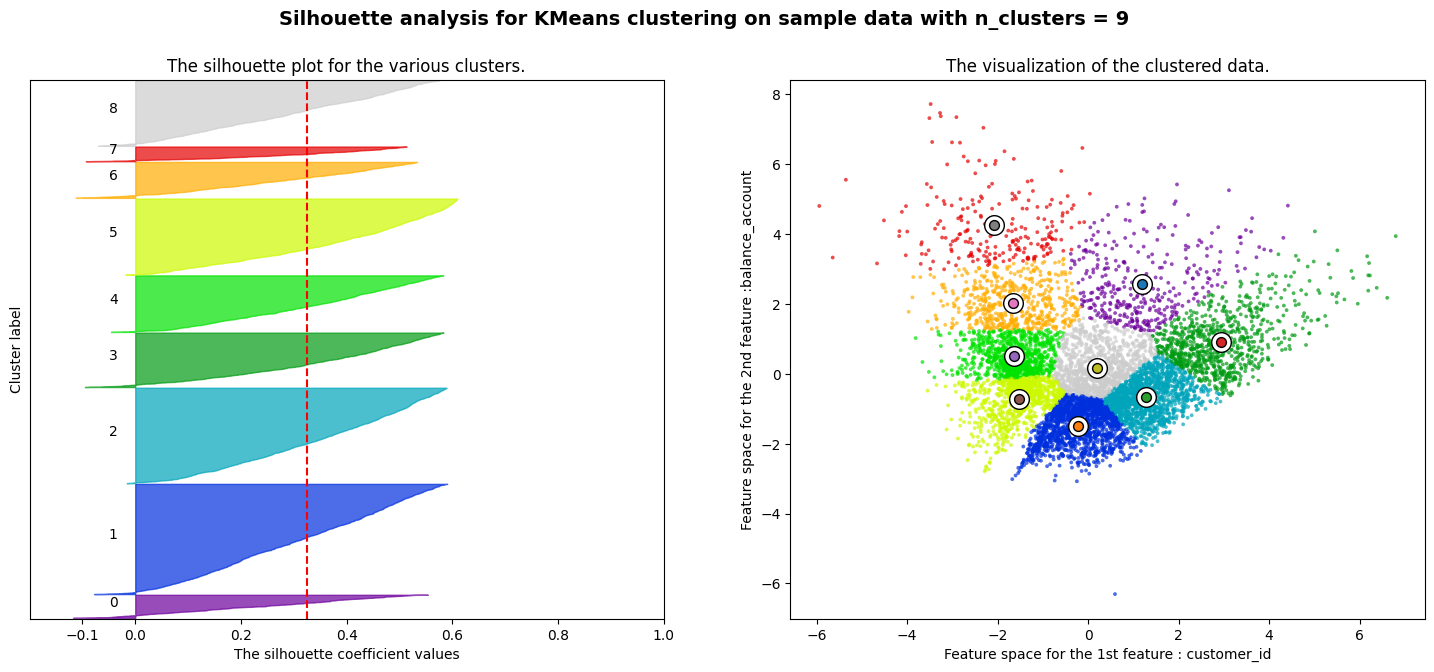

In [ ]:
X = reduced_data2#.to_numpy()

range_n_clusters = range(2, 10)

r_seed = 17

cols = df.columns

for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility.
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =",
          n_clusters,
          "The average silhouette_score is :",
          silhouette_avg.round(4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i + 1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / n_clusters)
    ax2.scatter(X[:, 0],
                X[:, 1],
                marker=".",
                s=30,
                lw=0,
                alpha=0.7,
                c=colors,
                edgecolor="k")

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature : " + cols[0])
    ax2.set_ylabel("Feature space for the 2nd feature :" + cols[1])

    plt.suptitle(
        (
            "Silhouette analysis for KMeans clustering on sample data "
            "with n_clusters = %d" % n_clusters
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
plt.show()

In [ ]:
cluster0.head()

paid_advance  balance_frequency_update  installments  purchases_frequency  \
3       0.000000                  1.000000          0.00             1.000000   
14      0.000000                  1.000000       2086.98             0.916667   
16   1201.188255                  1.000000         81.86             1.000000   
17    814.086208                  1.000000        202.91             0.916667   
22      0.000000                  0.833333        959.79             0.833333   

    full_purchases_frequency  credit_limit  fixed_rate_period     payments  \
3                   1.000000        2000.0                 12   704.240770   
14                  0.916667       12000.0                 12  3376.573790   
16                  1.000000        7500.0                 12  3273.326636   
17                  0.750000        1700.0                 12  1668.192483   
22                  0.666667        1200.0                  6   669.039640   

    min_payments  full_payment_prc  Avg_Purchase_Amount  Cash_Advance_Ratio  \
3     795.859808               0.0            27.936923            0.000000   
14    910.942173               0.0            55.064795            0.000000   
16    718.558976               0.0            42.383000           12.000048   
17    585.993296               0.0            24.711698           12.000000   
22    336.880119               0.5            79.120000            0.000000   

    Purchase_to_Balance_Ratio  kmean_cluster  
3                    0.179646              0  
14                   1.142996              0  
16                   0.309398              0  
17                   0.961746              0  
22                   3.901847              0

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Definir los 4 clusters
clusters = [cluster0, cluster1, cluster2, cluster3]
cluster_titles = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# Crear una figura con un grid de 2 filas y 2 columnas
fig = make_subplots(rows=2, cols=2, subplot_titles=cluster_titles)

# Listado de las columnas que deseas graficar en los histogramas
columns_to_plot = ['paid_advance', 'balance_frequency_update', 'installments',
                   'purchases_frequency', 'full_purchases_frequency', 'credit_limit']

# Para cada cluster, agregar los histogramas correspondientes
for i, cluster in enumerate(clusters):
    row = i // 2 + 1  # Calcular fila (1 o 2)
    col = i % 2 + 1   # Calcular columna (1 o 2)

    # Para cada columna a graficar, crear un histograma
    for column in columns_to_plot:
        hist = go.Histogram(x=cluster[column], name=column)
        fig.add_trace(hist, row=row, col=col)

# Actualizar el diseño de la figura
fig.update_layout(
    title_text="Histograms of Clusters",
    showlegend=True,
    height=800,  # Tamaño de la figura
    width=1000,  # Tamaño de la figura
    template='plotly_dark'  # Puedes cambiar el estilo de la plantilla
)

# Mostrar la figura
fig.show()


#Feature Importance using Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split



# Combine your clusters into one DataFrame
df_combined = pd.concat([cluster0, cluster1, cluster2, cluster3], ignore_index=True)

# Create an array of the features
X = df_combined.drop(columns=['kmean_cluster'])

# Target variable: the cluster labels
y = df_combined['kmean_cluster']

# Split the data into training and testing sets (optional, but helpful)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the importance
importance_df


Feature  Importance
0                paid_advance    0.271360
4    full_purchases_frequency    0.179515
2                installments    0.117343
3         purchases_frequency    0.088805
5                credit_limit    0.081648
7                    payments    0.063216
11         Cash_Advance_Ratio    0.059242
8                min_payments    0.037180
12  Purchase_to_Balance_Ratio    0.029283
9            full_payment_prc    0.023714
1    balance_frequency_update    0.019713
10        Avg_Purchase_Amount    0.016444
6           fixed_rate_period    0.012538

-   **Paid advances** and **full purchase frequency** are the most important factors in clustering users.
-   **Installments** and **purchase frequency** also have a moderate impact.
-   Features like **credit limit**, **payments**, and **cash advance ratio** also provide useful information but are less important than the top features.
-   The least important features are **balance frequency update**, **average purchase amount**, and **fixed-rate period**, indicating that these may not significantly impact the cluster definitions.


# Centroid Analysis (Cluster Centers)


In [ ]:

#Calculate the mean for each feature in each cluster

cluster_centroids = {
    'Cluster 0': cluster0.mean(),
    'Cluster 1': cluster1.mean(),
    'Cluster 2': cluster2.mean(),
    'Cluster 3': cluster3.mean()
}

# Display the centroids
import pandas as pd
centroids_df = pd.DataFrame(cluster_centroids)
centroids_df.T  # Transpose to make clusters the rows


paid_advance  balance_frequency_update  installments  \
Cluster 0    219.157351                  0.965325    980.119075   
Cluster 1    175.046369                  0.796748    190.407883   
Cluster 2   2418.560675                  0.926253     84.551298   
Cluster 3   6552.682245                  0.949646   1548.807873   

           purchases_frequency  full_purchases_frequency  credit_limit  \
Cluster 0             0.903297                  0.522271   6262.655232   
Cluster 1             0.433730                  0.095424   2704.407299   
Cluster 2             0.158117                  0.061132   5079.967056   
Cluster 3             0.602144                  0.324214  11076.507937   

           fixed_rate_period      payments  min_payments  full_payment_prc  \
Cluster 0          11.860849   2328.416582    649.554847          0.329878   
Cluster 1          11.341212    658.109440    437.940479          0.124167   
Cluster 2          11.460728   1802.707899   1380.577223          0.031975   
Cluster 3          11.771429  10517.571162   4195.497256          0.117696   

           Avg_Purchase_Amount  Cash_Advance_Ratio  Purchase_to_Balance_Ratio  \
Cluster 0            92.539442            3.448049                   9.265477   
Cluster 1            75.429168            4.596517                  36.742705   
Cluster 2            40.902453           25.312243                   0.176064   
Cluster 3           146.296192           32.748628                   1.484969   

           kmean_cluster  
Cluster 0            0.0  
Cluster 1            1.0  
Cluster 2            2.0  
Cluster 3            3.0

In [ ]:
from google.colab import files
transposed_centroids_df = centroids_df.T
transposed_centroids_df.to_csv('transposed_centroids.csv', index=False)
files.download('transposed_centroids.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's analyze the centroids of each cluster based on the calculated means for each feature.

### Cluster 0
- **Paid Advance**: 219.16 — This is a relatively low value, indicating that people in this cluster likely have a lower level of paid advance.
- **Balance Frequency Update**: 0.97 — A high value, meaning that users in this cluster frequently update their balance, which could indicate active account management.
- **Installments**: 980.12 — A moderate value. This suggests that users in this cluster have a moderate number of installment payments.
- **Purchases Frequency**: 0.90 — This is high, indicating frequent purchasing behavior.
- **Full Purchases Frequency**: 0.52 — This suggests that half of the purchases made by these users are full purchases (not installments).
- **Credit Limit**: 6262.66 — A moderate credit limit, meaning these users generally have a decent amount of credit available.
- **Fixed Rate Period**: 11.86 — A high value, meaning these users are likely in long-term fixed-rate periods.
- **Payments**: 2328.42 — A high payment value, showing these users tend to make large payments.
- **Min Payments**: 649.55 — A moderate minimum payment.
- **Full Payment Percentage**: 0.33 — A low percentage of users in this cluster are making full payments, suggesting many users are paying installments or partial payments.
- **Average Purchase Amount**: 92.54 — Relatively low, suggesting these users make smaller purchases on average.
- **Cash Advance Ratio**: 3.45 — High, indicating a significant proportion of purchases are cash advances.
- **Purchase to Balance Ratio**: 9.27 — This is very high, which suggests that these users are spending much more than their current balance, possibly taking on a lot of debt.

#### Interpretation for Cluster 0:
This cluster could represent **"Frequent Purchasers with Moderate Credit Use"**. They make frequent purchases, have a moderate credit limit, but often carry a large balance compared to their available credit. Many users in this cluster also use cash advances frequently and may not be making full payments.


### Cluster 1
- **Paid Advance**: 175.05 — Low, meaning these users engage less with paid advances.
- **Balance Frequency Update**: 0.80 — Moderate, indicating these users update their balances fairly regularly.
- **Installments**: 190.41 — Low, suggesting these users have fewer installment payments.
- **Purchases Frequency**: 0.43 — Low, meaning users in this cluster make fewer purchases overall.
- **Full Purchases Frequency**: 0.10 — Very low, indicating that most purchases are not full payments.
- **Credit Limit**: 2704.41 — Low, indicating limited credit availability.
- **Fixed Rate Period**: 11.34 — Moderate, meaning these users are likely in medium-length fixed-rate periods.
- **Payments**: 658.11 — Low, indicating smaller payments overall.
- **Min Payments**: 437.94 — Low, suggesting users are paying relatively little toward their debt.
- **Full Payment Percentage**: 0.12 — Very low, suggesting most users in this cluster only make partial payments.
- **Average Purchase Amount**: 75.43 — Low, meaning the average purchase amount is relatively small.
- **Cash Advance Ratio**: 4.60 — Higher than average, indicating that a significant portion of these users' purchases are cash advances.
- **Purchase to Balance Ratio**: 36.74 — Very high, suggesting these users are carrying large balances compared to their credit limits.

#### Interpretation for Cluster 1:
This cluster could represent **"Low-Spending, High Cash Advance Users"**. They have lower overall spending and credit limits, but they make a relatively high number of cash advances. Many users in this cluster are also not making full payments.


### Cluster 2
- **Paid Advance**: 2418.56 — Very high, indicating these users have a significant amount of paid advances.
- **Balance Frequency Update**: 0.93 — High, suggesting these users are actively managing their balance.
- **Installments**: 84.55 — Low, indicating fewer installment payments.
- **Purchases Frequency**: 0.16 — Very low, meaning these users are not making many purchases.
- **Full Purchases Frequency**: 0.06 — Very low, suggesting most purchases are not full payments.
- **Credit Limit**: 5079.97 — Moderate, indicating moderate credit availability.
- **Fixed Rate Period**: 11.46 — Moderate, suggesting users are in medium-length fixed-rate periods.
- **Payments**: 1802.71 — Moderate, showing that these users make average payments.
- **Min Payments**: 1380.58 — Relatively high, suggesting users are meeting a significant portion of their minimum payments.
- **Full Payment Percentage**: 0.03 — Very low, indicating very few users are making full payments.
- **Average Purchase Amount**: 40.90 — Low, suggesting users are making smaller purchases.
- **Cash Advance Ratio**: 25.31 — Very high, indicating a very significant portion of these users' activity involves cash advances.
- **Purchase to Balance Ratio**: 0.18 — Very low, suggesting users are not spending much compared to their available balance.

#### Interpretation for Cluster 2:
This cluster could represent **"Cash Advance Heavy Users with Low Spending"**. They engage heavily in cash advances but make fewer purchases and have smaller spending activity overall. These users often pay their minimum balance but rarely make full payments.


### Cluster 3
- **Paid Advance**: 6552.68 — Extremely high, indicating these users have a significant amount of paid advances.
- **Balance Frequency Update**: 0.95 — High, suggesting users are frequently updating their balance.
- **Installments**: 1548.81 — High, showing these users have many installment payments.
- **Purchases Frequency**: 0.60 — Moderate, meaning these users make a moderate number of purchases.
- **Full Purchases Frequency**: 0.32 — Moderate, indicating that a significant portion of purchases are full payments.
- **Credit Limit**: 11076.51 — Very high, indicating that these users have a large credit limit.
- **Fixed Rate Period**: 11.77 — High, suggesting that these users are typically in long-term fixed-rate periods.
- **Payments**: 10517.57 — Very high, meaning these users are making large payments.
- **Min Payments**: 4195.50 — High, suggesting users are consistently making large minimum payments.
- **Full Payment Percentage**: 0.12 — Low, indicating that most users in this cluster are not making full payments.
- **Average Purchase Amount**: 146.30 — Relatively high, indicating users are making larger purchases.
- **Cash Advance Ratio**: 32.75 — Extremely high, indicating a very large portion of these users' activity is cash advances.
- **Purchase to Balance Ratio**: 1.48 — Moderate, indicating these users spend more than their available balance.


#### Interpretation for Cluster 3:
This cluster could represent **"High-Spending Users with Large Credit and Cash Advances"**. They have high credit limits, make large payments, and have a significant amount of cash advance activity. They also make relatively large purchases compared to their available balance.


### Summary from Method 1:
- **Cluster 0**: **Frequent Purchasers with Moderate Credit Use**.
- **Cluster 1**: **Low-Spending, High Cash Advance Users**.
- **Cluster 2**: **Cash Advance Heavy Users with Low Spending**.
- **Cluster 3**: **High-Spending Users with Large Credit and Cash Advances**.


# Cluster Profiling

In [ ]:
# Combine the clusters into a single dataframe
df_combined = pd.concat([cluster0, cluster1, cluster2, cluster3], ignore_index=True)

# Group by the cluster label
cluster_profiles = df_combined.groupby('kmean_cluster').describe()

# Display the statistical summary for each cluster
cluster_profiles


In [ ]:
pd.options.display.max_columns = None
cluster_profiles

-   **Cluster 0**: Characterized by high credit limits, frequent purchases, and moderate paid advances. Individuals in this cluster may be higher-spending customers, likely to have larger credit limits and make significant purchases.
-   **Cluster 1**: Shows more modest credit limits and lower purchasing activity. These individuals may be less engaged in spending and have more modest credit profiles.
-   **Cluster 2**: This cluster shows high paid advances but low purchasing frequency and small credit limits. They may be cautious spenders who prefer to pay in advance but don’t use credit often.
-   **Cluster 3**: With the highest paid advances and credit limits, this group likely represents high-spending customers who make larger purchases and use significant credit, possibly with occasional cash advances.


# OUR final interpretations:

-   **Cluster 0**: Characterized by clients with an average of $6262.66 credit limits, frequent purchases, and moderate paid advances. Individuals in this cluster may be higher-spending customers, likely to have larger credit limits and make significant purchases.(Purchase to Balance Ratio: 9.27). these users have a low credit but big debt.

-   **Cluster 1**:
These users are "cash lovers," adhering to the traditional "cash is king" mindset. The relatively low Average Purchase Amount of $92.54 indicates that the bank does not have many registered purchases made with the credit card. On the other hand, they frequently convert their available credit into cash, as reflected by the high Cash Advance Ratio of 4.60, which is above average. This practice increases their interest charges and in addittion to these users rarely make full payments, limits their ability to have their credit limit expande (Credit Limit Average: 2704.41).

-   **Cluster 2**: This cluster shows high paid advances but low purchasing frequency and small credit limits. They may be cautious spenders who prefer to pay in advance but don’t use credit often.
nice to have it, not to explode it, like to use cash, therefore not dependent on installments. likes immediate forms of payment.

-   **Cluster 3**: With the highest paid advances and credit limits, this group likely represents high-spending customers who make larger purchases and use significant credit. Highly educated and experienced credit line users. They don´t put the business model in risk, they know how to manage debt.


1) Pre-processing / Data exploration -> NA, feature enginering PCA
2) Clustering -> 4 clusters
3) Interpretation
4) Marketing suggestions